In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SUL DATASET**

Il dataset è una versione pre-processata del dataset **OASIS Alzheimer's Detection** (un dataset di immagini MRI del cervello di 461 pazienti) utilizzato per rilevare i segni precoci dell’Alzheimer.

Poiché le immagini MRI sono 3D, sono state divise lungo l'asse z (l'asse della profondità del cervello) in 175 fette e sono state selezionate le fette che vanno dalla 65esima alla 110ecima al fine di ridurre il numero di immagini e concentrarsi sulle sezioni cerebrali rilevanti per l'analisi della demenza; Questo approccio ha generato immagini 2D per ogni paziente.

Lo stesso approccio è stato utilizzato per le versioni delle MRI con segmentazione delle aree cerebrali offerte da OASIS effettuate tramite FSL FAST.

****
****

Le immagini sono classificate in **quattro sottoclassi**, in base alla progressione della malattia:

*   Moderate dementia (affetto da demenza)

*   Very mild dementia (affetto da demenza molto lieve)
* Mild dementia (affetto da demenza lieve)
* Non-demented (non affetto da demenza)


*La classificazione dei pazienti è stata effettuata sulla base delle valutazioni CDR (Clinical Dementia Rating), un punteggio che valuta la severità della demenza.*



In [2]:
# Import

import math
import os
import pickle
import random
import shutil
import zipfile
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numba import njit
from numpy.lib.stride_tricks import as_strided
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from sklearn.metrics import fbeta_score

# **OPERAZIONI SUL DATASET**

### *Operazioni preliminari*

In [65]:
# Estrazione dataset

ds_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ds.zip'
if not os.path.exists(ds_path):
  print(f"La cartella {ds_path} non esiste. Procedo con l'estrazione...")

  zip_path = "/content/drive/My Drive/Alzheimer-detection-project/oasis 1.zip"
  extract_folder = "/content/Alzheimer-detection-project"

  os.makedirs(extract_folder, exist_ok=True)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
  print("File estratti:", os.listdir(extract_folder))

else:
  print(f"La cartella {ds_path} esiste. Procedo con la copia...")
  zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/train_ds.zip"
  extract_folder = '/content/Alzheimer-detection-project'
  oasis1_path = os.path.join(extract_folder, "oasis 1")

  os.makedirs(oasis1_path, exist_ok=True)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(oasis1_path)

La cartella /content/drive/MyDrive/Alzheimer-detection-project/train_ds.zip esiste. Procedo con la copia...


In [66]:
# Definizione path

oasis1_path = os.path.join(extract_folder, "oasis 1")
if not os.path.exists(ds_path):
  categories = ['Moderate Dementia', 'Mild Dementia', 'Very Mild Dementia', 'Non Demented']
else:
  categories = ['Mild to Moderate Dementia', 'Very Mild Dementia', 'Non Demented']
for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')

In [67]:
# Rimozione files inutili

for dirpath, dirnames, filenames in os.walk(oasis1_path):
  for filename in filenames:
    if filename == ".DS_Store":
      file_path = os.path.join(dirpath, filename)
      os.remove(file_path)
      print(f"Rimosso: {file_path}")

### *VISUALIZZAZIONE GRAFICI di distribuzione delle classi*

numero foto Moderate Dementia: 92
numero foto Mild Dementia: 1288
numero foto Very Mild Dementia: 3220
numero foto Non Demented: 15456


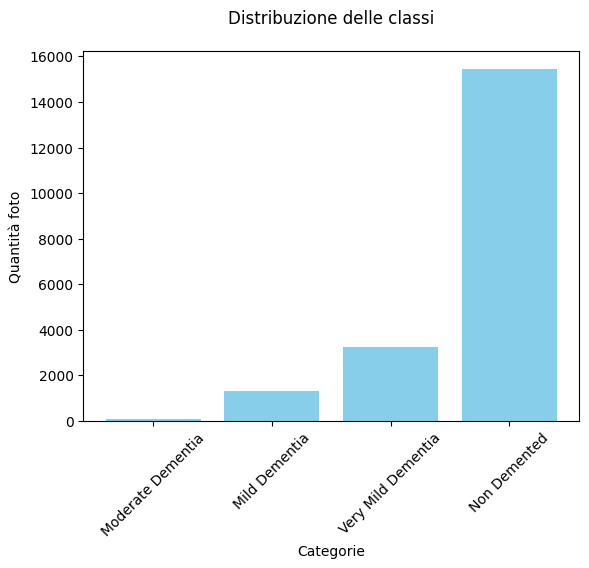

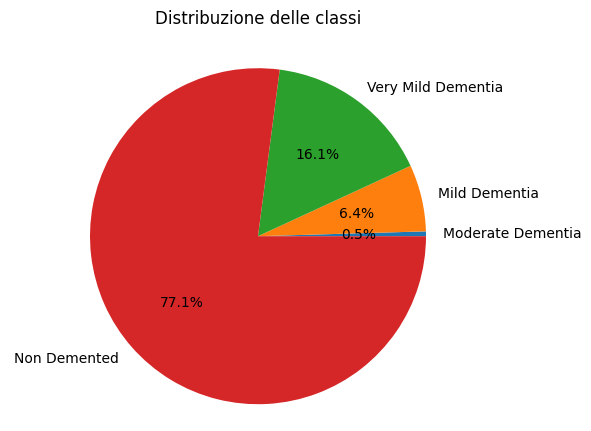

In [ ]:
# Numero di immagini per categoria - grafico di distribuzione delle classi

somma=0
valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero immagini {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()

### *APPROCCI ALLO SBILANCIAMENTO DEL DATASET*

Il dataset è estremamente sbilanciato.

 **APPROCCI ADOTTATI PER AFFRONTARE IL PROBLEMA DELLO SBILANCIAMENTO**:

- **Unione delle due classi minoritarie** (Mild Dementia e Moderate Demenntia) dato che il focus del progetto è una early detection dell'alzheimer.
- **Downsampling parziale della classe maggioritaria** (Non Demented) per limitare il rischio di bias.
- **Bilanciamento delle classi tramiti pesi** (class weights) durante la fase di addestramento per compensare le differenze residue.

In [ ]:
# Sposto i files da Moderate dementia in Mild Dementia

mod_d_path=os.path.join(oasis1_path, "Moderate Dementia")
mild_d_path=os.path.join(oasis1_path, "Mild Dementia")
source_path=os.path.join(mod_d_path, "mri scan")
dest_path=os.path.join(mild_d_path, "mri scan")

for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

source_path=os.path.join(mod_d_path, "mri segmented")
dest_path=os.path.join(mild_d_path, "mri segmented")
for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

In [ ]:
# Rinomino la cartella

mild_to_mod_path= os.path.join(oasis1_path, "Mild to Moderate Dementia")
if os.path.exists(mild_d_path):
    os.rename(mild_d_path, mild_to_mod_path)
    print("Cartella rinominata con successo.")
else:
    print("La cartella di origine non esiste.")
categories = ['Mild to Moderate Dementia', 'Very Mild Dementia', 'Non Demented']

# Elimino la cartella vuota
cartella_da_eliminare = os.path.join(oasis1_path, "Moderate Dementia")
shutil.rmtree(cartella_da_eliminare)

Cartella rinominata con successo.


In [ ]:
# Downsampling della classe maggioritaria

nd_path=os.path.join(oasis1_path, "Non Demented")
mri_path=os.path.join(nd_path, "mri scan")
mri_seg_path=os.path.join(nd_path, "mri segmented")

n=200
folders=os.listdir(mri_path)
to_delete=random.sample(folders, n)

for folder in to_delete:
  folder_seg= f"{folder.strip()} seg"
  path=os.path.join(mri_path, folder)
  path_seg=os.path.join(mri_seg_path, folder_seg)
  shutil.rmtree(path)
  shutil.rmtree(path_seg)

### *VISUALIZZAZIONE GRAFICI di distribuzione delle classi in seguito a approcci per il bilanciamento*

numero foto Mild to Moderate Dementia: 1380
numero foto Very Mild Dementia: 3220
numero foto Non Demented: 6256


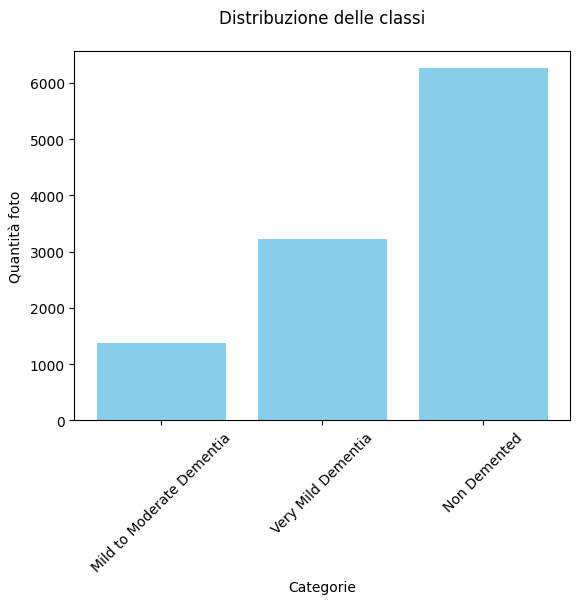

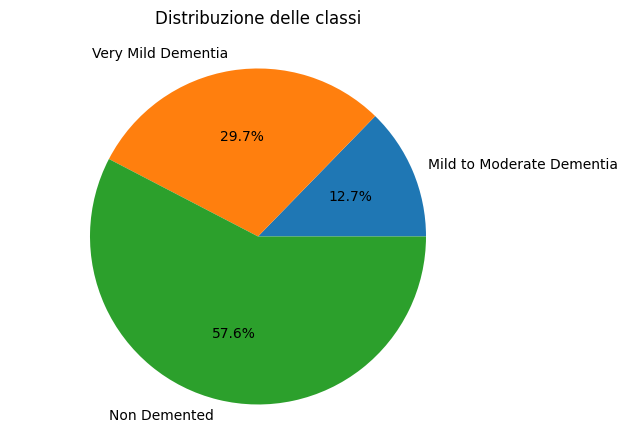

In [ ]:
# Numero di immagini per categoria - grafico di distribuzione delle classi
#dopo unione delle cartelle e downsampling

somma=0
valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()

### *VISUALIZZAZIONE DI IMMAGINI A CAMPIONE*

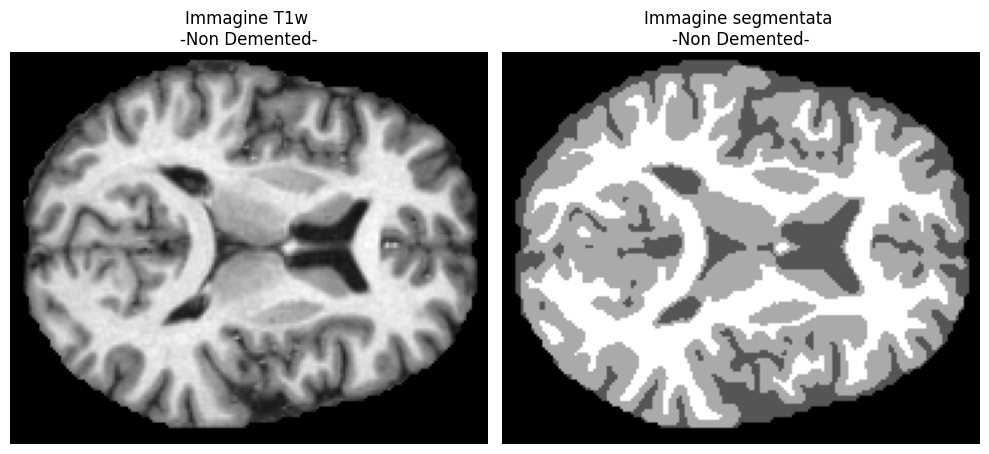

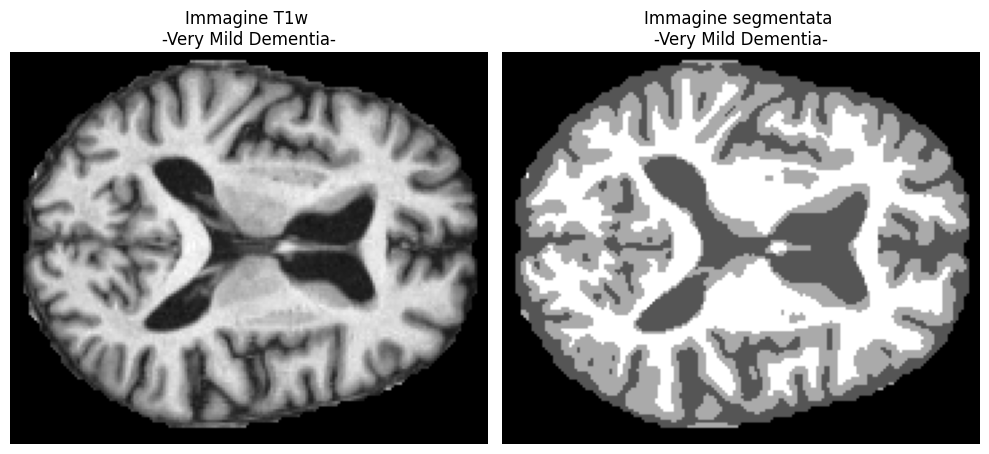

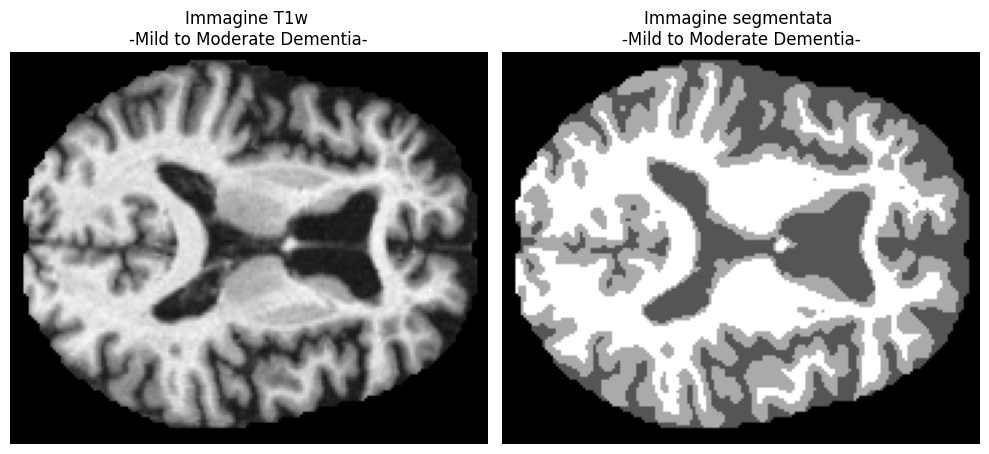

In [ ]:
#VISUALIZZAZIONE DI IMMAGINI A CAMPIONE

# Stampa di un immagine segmentata e un immagine T1w per categoria
for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')
  folders=os.listdir(mri_path)
  random_folder = random.choice(folders)
  random_folder_seg= f"{random_folder.strip()} seg"

  patient_path= os.path.join(mri_path, random_folder)
  patient_path_seg= os.path.join(mri_segmented_path, random_folder_seg)

  img_path = os.path.join(patient_path, 'slice_85.png')
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_seg, 'slice_85.png')
  img_seg = mpimg.imread(img_seg_path)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img, cmap='gray')
  axes[0].set_title(f"Immagine T1w \n-{category}-")
  axes[0].axis('off')

  axes[1].imshow(img_seg)
  axes[1].set_title(f"Immagine segmentata \n-{category}-")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()

4 valori differenti: [0.         0.33333334 0.6666667  1.        ]




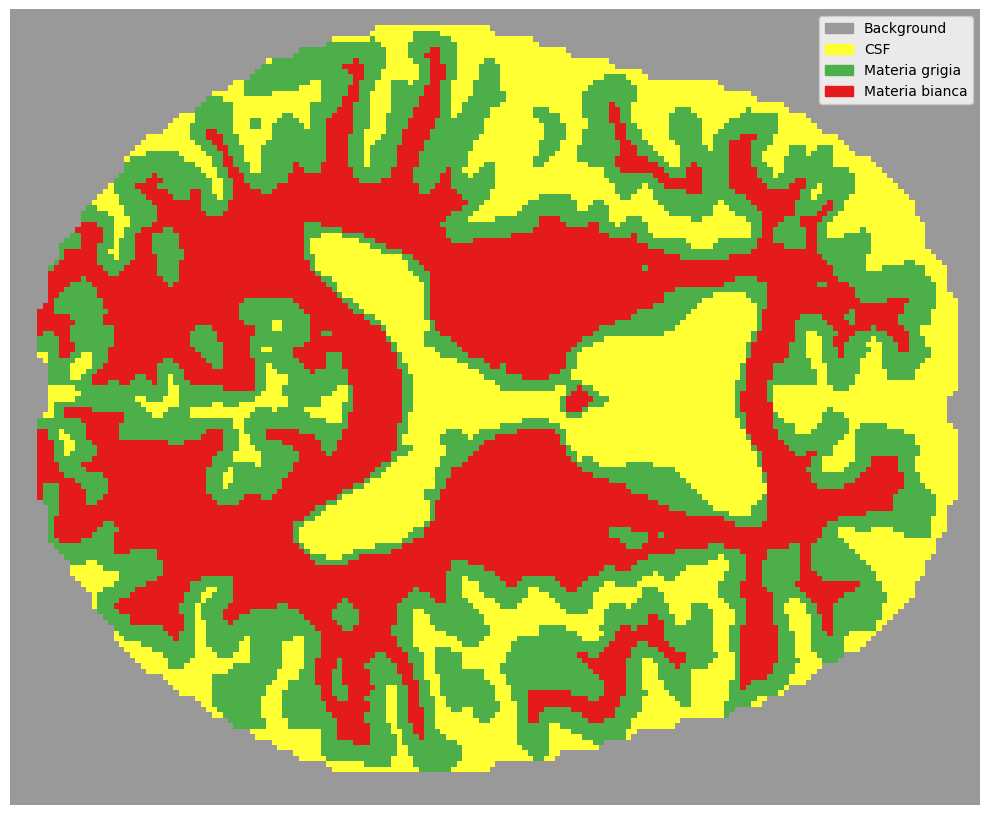

In [ ]:
# Visualizzazione con etichette delle immagini segmentate

# Scelta di un immagine segmentata

img_seg = mpimg.imread(img_seg_path)
img_seg = img_seg[:, :, 0]

labels=['Background', 'CSF', 'Materia grigia', 'Materia bianca']
valori_unici = np.unique(img_seg)
print(f"{len(valori_unici)} valori differenti: {valori_unici}\n\n")

# creazione della leggenda e visualizzazione
cmap = plt.cm.Set1_r
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_seg, cmap=cmap)

patches = []
for i, val in enumerate(valori_unici):
  patch = mpatches.Patch(color=cmap(val), label=labels[i])
  patches.append(patch)
ax.legend(handles=patches, loc='upper right')

ax.axis('off')
plt.tight_layout()
plt.show()

I valori dell'output segmentato sono normalizzati e lo standard è:

| Valore         | Etichetta         |  
|----------------|-------------------|
| `0.0`          | **Background**     |
| `0.33333334`   | **CSF**            |
| `0.6666667`    | **Materia Grigia** |
| `1.0`          | **Materia Bianca** |

### *OPERAZIONI SU DIMENSIONI E CANALI*

In [68]:
# Conversione delle immagini MRI in scale di grigi
# Utilizzo Grayscale = 0.299 * R + 0.587 * G + 0.114 * B

def convert_images_to_grayscale(image_paths):
  for image_path in image_paths:
    img = mpimg.imread(image_path)
    if len(img.shape) == 3 and img.shape[2] >= 3:
      rgb = img[..., :3]  # Prendi solo R, G, B
      gray = 0.299 * rgb[..., 0] + 0.587 * rgb[..., 1] + 0.114 * rgb[..., 2]
      gray = (gray * 255).astype(np.uint8) if gray.max() <= 1 else gray.astype(np.uint8)

      gray_img = Image.fromarray(gray)
      gray_img.save(image_path)

In [69]:
# Funzione per il controllo del numero di canali e delle dimensioni di immagini da una lista

def check_image_dimensions_and_channels_from_list(image_paths):
  images_dimentions = set()
  images_channels = set()

  for image_path in image_paths:
    i = mpimg.imread(image_path)
    w, h = i.shape[:2]
    images_dimentions.add((w, h))
    if len(i.shape) == 3:
      channels = i.shape[2]
    else:
      channels = 1
    images_channels.add(channels)

  # Controllo del numero di elementi negli insiemi
  if len(images_dimentions) == 1:
    print("Tutte le immagini hanno le stesse dimensioni:", images_dimentions.pop())
  else:
    print("NON tutte le immagini hanno le stesse dimensioni:")
    for dim in images_dimentions:
      print(" ", dim)

  if len(images_channels) == 1:
    print("Tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
  else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
      print(" ", ch)

In [70]:
# Check dimensioni e canali

image_paths=[]
# Per ogni immagine in ogni categoria salva dimensioni e numero di canale negli insiemi
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      images= os.listdir(os.path.join(mri_path, patient))
      for image in images:
        image_path=os.path.join(patient_path, image)
        image_paths.append(image_path)

check_image_dimensions_and_channels_from_list(image_paths)

Tutte le immagini hanno le stesse dimensioni: (146, 178)
Tutte le immagini hanno lo stesso numero di canali: 1


In [71]:
# Conversione delle immagini MRI in scale di grigi
convert_images_to_grayscale(image_paths)
# Check del nuovo numero di canali
check_image_dimensions_and_channels_from_list(image_paths)

Tutte le immagini hanno le stesse dimensioni: (146, 178)
Tutte le immagini hanno lo stesso numero di canali: 1


### *DEVIAZIONE STANDARD E MSE*

 **DEVIAZIONE STANDARD --> misura dove variano di più i pixel**

- STD ALTA: molta variabilità nei valori dei pixel

- STD BASSA: poca variabilità nei valori dei pixel

**MEAN SQUARE ERROR --> misura quanto ogni pixel si allontana dalla media**

- MSE ALTO: alta variabilità intra-classe

- MSE BASSO: bassa variabilità intra-classe

In [ ]:
# Calcolo della deviazione standard e mse

std_interclasse= {}
mse_interclasse={}
std_intraclasse={}
mse_intraclasse={}

selected_slices = ['slice_66.png', 'slice_80.png', 'slice_95.png', 'slice_107.png']

for name in selected_slices:
  slices_all_categories = []
  for category in categories:
    slices = []
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      slice_of_interest= os.path.join(patient_path, name)
      i = Image.open(slice_of_interest)
      i_array = np.array(i)
      slices.append(i_array)

    if slices:
      slices_stack_interclasse = np.stack(slices)
      std_map_interclasse = np.std(slices_stack_interclasse, axis=0)
      mean_slice_interclasse = np.mean(slices_stack_interclasse, axis=0)
      mse_map_interclasse = np.mean((slices_stack_interclasse - mean_slice_interclasse) ** 2, axis=0)
      mse_interclasse[(name,category)] = mse_map_interclasse
      std_interclasse[(name, category)] = std_map_interclasse

      slices_all_categories.extend(slices)

  if slices_all_categories:
    slices_stack_intraclasse = np.stack(slices_all_categories)
    std_map_intraclasse = np.std(slices_stack_intraclasse, axis=0)
    mean_slice_intraclasse = np.mean(slices_stack_intraclasse, axis=0)
    mse_map_intraclasse = np.mean((slices_stack_intraclasse - mean_slice_intraclasse) ** 2, axis=0)
    std_intraclasse[name] = std_map_intraclasse
    mse_intraclasse[name] = mse_map_intraclasse

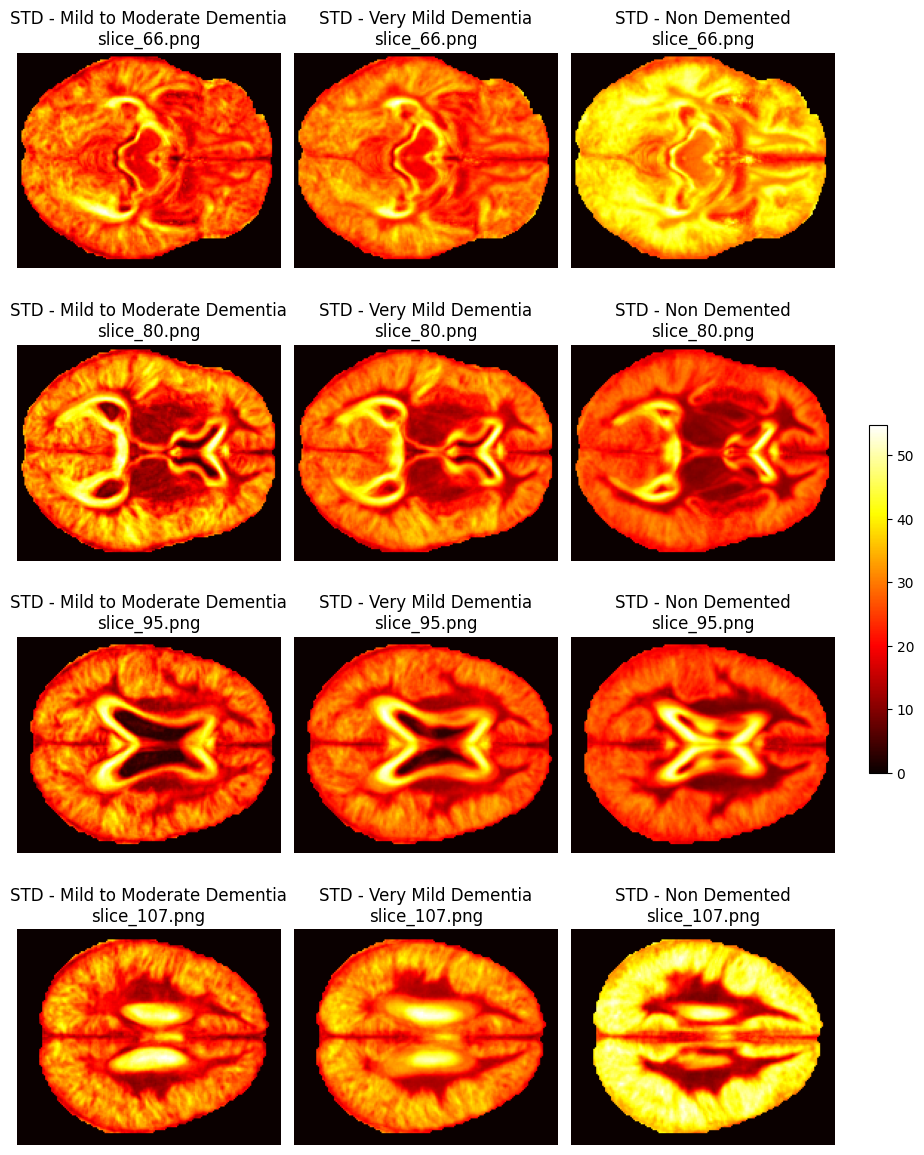

In [ ]:
#  Visualizzazione della deviazione standard (sulla stessa slice) intra classe

columns = 3
imgs = len(std_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), std_map_interclasse) in enumerate((std_interclasse.items())):
  plt.subplot(rows, columns, idx + 1)
  im = plt.imshow(std_map_interclasse, cmap='hot')
  plt.title(f"STD - {category}\n{name}")
  plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

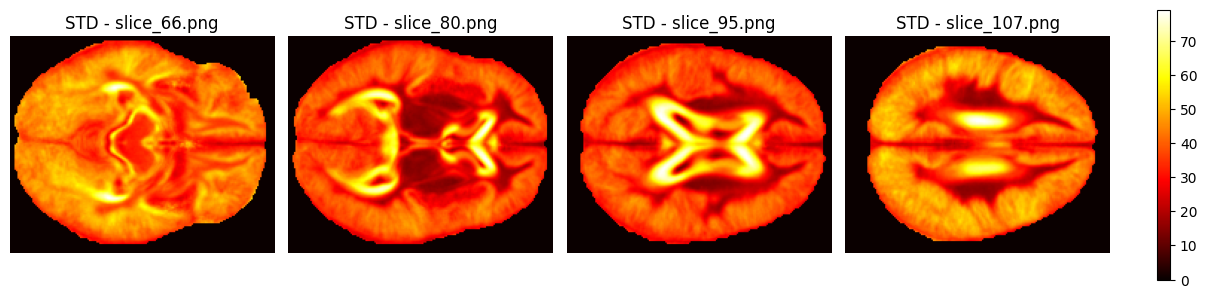

In [ ]:
# Visualizzazione della deviazione standard (sulla stessa slice) inter classe

columns = 4
imgs = len(std_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, std_map_intraclasse) in enumerate(std_intraclasse.items()):
  plt.subplot(rows, columns, idx + 1)
  im = plt.imshow(std_map_intraclasse, cmap='hot')
  plt.title(f"STD - {name}")
  plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

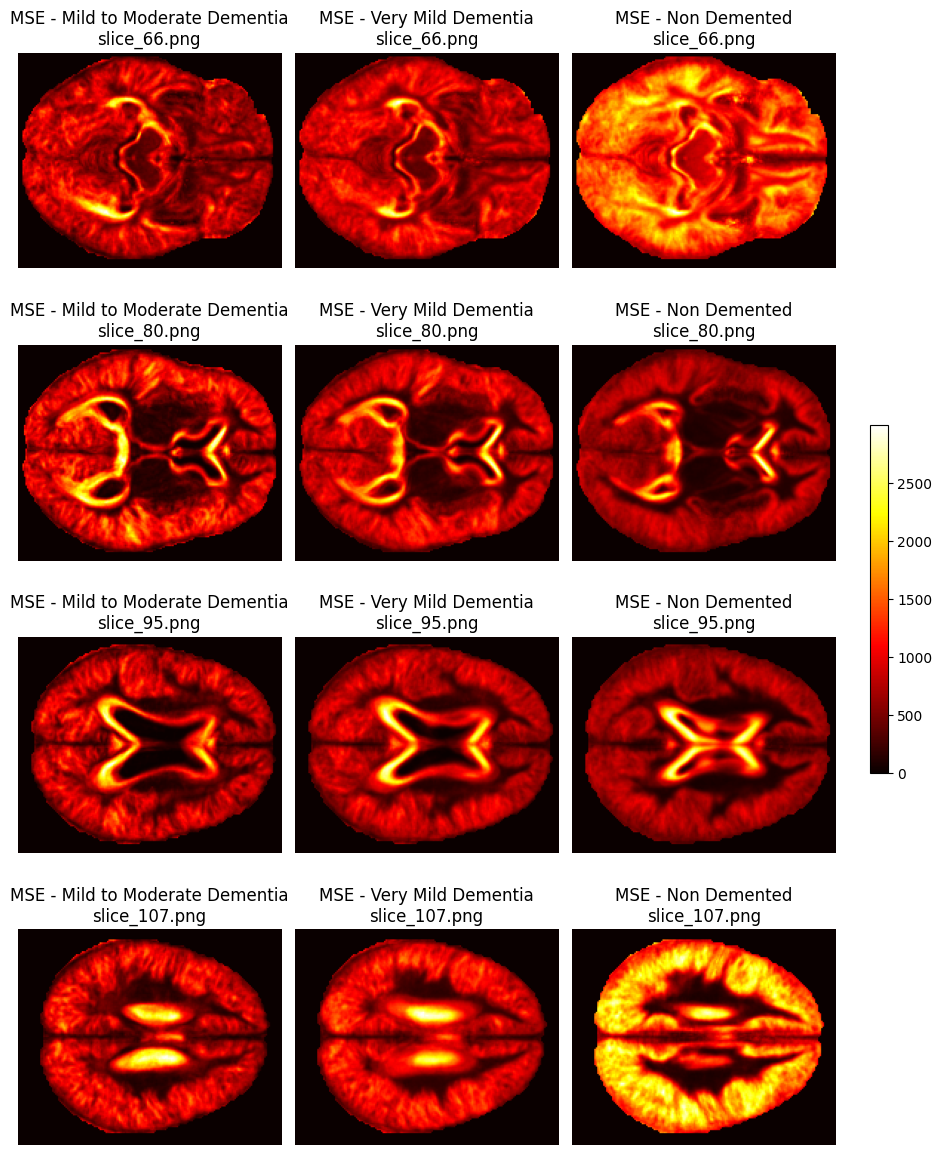

In [ ]:
# Visualizzazione dell'MSE (sulla stessa slice) intra classe

columns = 3
imgs = len(mse_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), mse_map_interclasse) in enumerate(mse_interclasse.items()):
  plt.subplot(rows, columns, idx + 1)
  im = plt.imshow(mse_map_interclasse, cmap='hot')
  plt.title(f"MSE - {category}\n{name}")
  plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

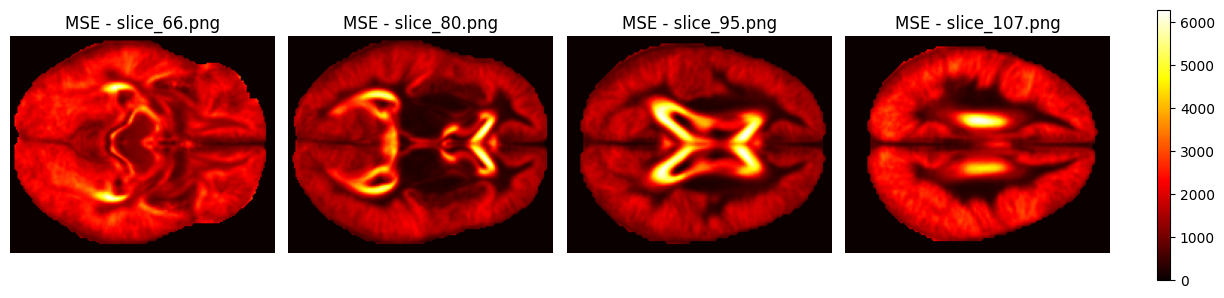

In [ ]:
# Visualizzazione dell'MSE (sulla stessa slice) inter classe

columns = 4
imgs = len(mse_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, mse_map_intraclasse) in enumerate(mse_intraclasse.items()):
  plt.subplot(rows, columns, idx + 1)
  im = plt.imshow(mse_map_intraclasse, cmap='hot')
  plt.title(f"MSE - {name}")
  plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

### *DIVISIONE IN TRAINING SET E TEST SET*

In [223]:
# Creo dataframe con tutti i pazienti e tutti i pazienti segmentati

labeled_patients=[]
segmented_patients=[]

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in os.listdir(mri_path):
    patient_seg= f"{patient.strip()} seg"
    patient_path=os.path.join(mri_path, patient)
    patient_seg_path=os.path.join(mri_segmented_path, patient_seg)
    labeled_patients.append((cat, patient))
    segmented_patients.append((cat, patient_seg))

df=pd.DataFrame(labeled_patients, columns=["label", "patient_id"])
df_seg=pd.DataFrame(segmented_patients, columns=["label", "patient_id"])

In [224]:
# Creo la split tra training-test-validation set
from sklearn.model_selection import train_test_split
if not os.path.exists(ds_path):
  train_x, test_x = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
  )

  train_x, val_x = train_test_split(
    train_x,
    test_size=0.2,
    random_state=42,
    stratify=train_x['label']
  )

  train_ids = train_x['patient_id'].tolist()
  val_ids = val_x['patient_id'].tolist()
  test_ids = test_x['patient_id'].tolist()

  train_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in train_ids])]
  val_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in val_ids])]
  test_y = df_seg[df_seg['patient_id'].isin([f"{pid} seg" for pid in test_ids])]

else:
  # Scarico gli id da drive
  print("li apro da drive")

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ids.pkl'
  with open(file_path, 'rb') as f:
    train_ids= pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/val_ids.pkl'
  with open(file_path, 'rb') as f:
    val_ids = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_ids.pkl'
  with open(file_path, 'rb') as f:
    test_ids = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_y.pkl'
  with open(file_path, 'rb') as f:
    train_y = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/val_y.pkl'
  with open(file_path, 'rb') as f:
    val_y = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_y.pkl'
  with open(file_path, 'rb') as f:
    test_y = pickle.load(f)

print("Numero di pazienti segmentati in train_y:", len(train_y))
print("Numero di pazienti in train_x:", len(train_ids))
print("Numero di pazienti segmentati in val_y:", len(val_y))
print("Numero di pazienti in val_x:", len(val_ids))
print("Numero di pazienti segmentati in test_y:", len(test_y))
print("Numero di pazienti in test_x:", len(test_ids))

li apro da drive
Numero di pazienti segmentati in train_y: 150
Numero di pazienti in train_x: 150
Numero di pazienti segmentati in val_y: 38
Numero di pazienti in val_x: 38
Numero di pazienti segmentati in test_y: 48
Numero di pazienti in test_x: 48


### *CONVERSIONE IMMAGINI SEGMENTATE IN MAPPE DI CLASSI*

In [354]:
# Funzione per la conversione di immagine segmentata in una mappa di classi intere
value_to_class = {
    0.0: 0,
    1/3: 1,
    2/3: 2,
    1.0: 3
}
class_names_seg=["Background", "CSF", "GM", "WM"]

def class_map(img, d):
  class_map = np.zeros_like(img, dtype=np.uint8)
  for val, class_id in d.items():
    mask = np.isclose(img, val)
    class_map[mask] = class_id
  return class_map

In [ ]:
# Conversione delle immagini segmentate in mappe

if not os.path.exists(ds_path):
  for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      patient_path= os.path.join(mri_segmented_path, patient)
      for filename in os.listdir(patient_path):
        img_path = os.path.join(patient_path, filename)
        img_seg = mpimg.imread(img_path)
        img_seg = img_seg[:, :, 0]
        classmap = class_map(img_seg, value_to_class)
        save_path = os.path.join(patient_path, filename.replace(".png", ".npy"))
        np.save(save_path, classmap)

### *SBILANCIAMENTO TRA CLASSI DELLA SEGMENTAZIONE*

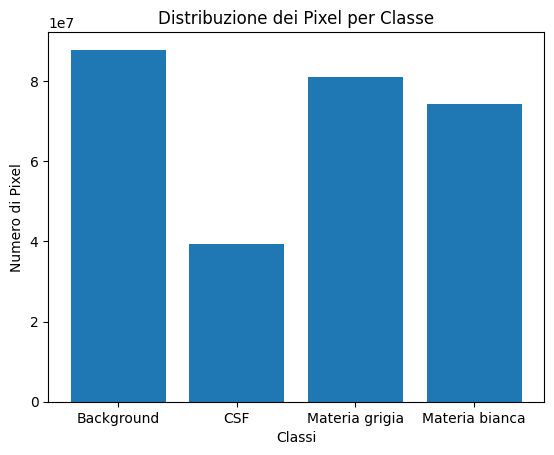

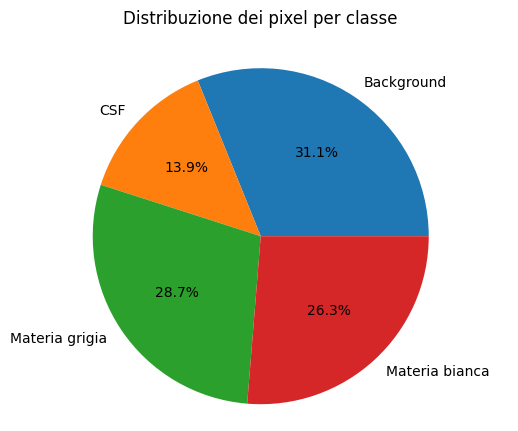

In [270]:
# Calcolo del numero di pixel per ogni classe per vedere se sono presenti sbilanciamenti

labels = ['Background', 'CSF', 'Materia grigia', 'Materia bianca']
total_counts = np.zeros(4, dtype=np.int64)
image_count = 0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      patient_path= os.path.join(mri_segmented_path, patient)
      for filename in os.listdir(patient_path):
        if not filename.endswith('.npy'):
          continue
        file_path = os.path.join(patient_path, filename)
        class_map = np.load(file_path)
        pixel_counts = np.bincount(class_map.flatten(), minlength=4)
        total_counts += pixel_counts
        image_count += 1
avg_counts = total_counts / image_count


# Visualizzazione tramite istogramma
plt.bar(labels, total_counts)
plt.xlabel('Classi')
plt.ylabel('Numero di Pixel')
plt.title('Distribuzione dei Pixel per Classe')
plt.show()

# Visualizzazione tramite grafico a torta
plt.pie(total_counts, labels=labels, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione dei pixel per classe',pad=20)
plt.axis('equal')
plt.show()

In [271]:
# Calcolo dei pesi per la loss function

pixels = avg_counts.sum()
class_weights = pixels /(4*avg_counts )

for class_id, weight in enumerate(class_weights):
  print(f"Classe {labels[class_id]}: Peso = {weight:.4f}")
class_weights = np.array(class_weights, dtype=np.float32)

Classe Background: Peso = 0.8034
Classe CSF: Peso = 1.7942
Classe Materia grigia: Peso = 0.8722
Classe Materia bianca: Peso = 0.9511


# **DEFINIZIONE DELLA U NET** per la segmentazione

## **FUNZIONI AUSILIARIE AL FORWARD PASS**

### *Funzioni di pooling e upsampling*

In [225]:
# Max pooling

def max_pooling(img, pool_size=2, stride=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]
  batch_size, img_height, img_width, img_channels = img.shape
  pool_height, pool_width = (pool_size, pool_size)
  output_height = (img_height - pool_height) // stride + 1
  output_width = (img_width - pool_width) // stride + 1
  output = np.zeros((batch_size, output_height, output_width, img_channels))
  for b in range(batch_size):
    for i in range(output_height):
      for j in range(output_width):
        row=i*stride
        column=j*stride
        for c in range(img_channels):
          window = img[b, row:row + pool_height, column:column + pool_width, c]
          output[b,i, j, c] = np.max(window)
  return output

In [226]:
# Upsampling

def upsample(img, scale=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]

  upsampled = np.repeat(img, scale, axis=1)
  upsampled = np.repeat(upsampled, scale, axis=2)

  return upsampled

### *Funzione di perdita* *(loss function)*

In [227]:
# Loss function e funzioni ausiliarie

def onehot_encoding(targets, n_classes):
  one_hot = np.eye(n_classes, dtype=np.uint8)[targets]
  return one_hot

def weighted_cross_entropy_loss(targets, predictions, class_weights):
  epsilon = 1e-7
  log_predictions = np.log(predictions + epsilon)
  cross_entropy = -np.sum(targets * log_predictions, axis=-1)
  weights = np.sum(targets * class_weights, axis=-1)
  weighted_cross_entropy = cross_entropy * weights
  loss = np.mean(weighted_cross_entropy)

  return loss

### *Funzioni di attivazione*

In [228]:
# ReLU (Leaky)

def ReLU(img):
  return np.where(img > 0, img, 0.01 * img)

In [229]:
# Softmax - per rendere l'output in probabilità per classe

def softmax(predictions, temperature=0.5):
  if predictions.ndim != 4:
    raise ValueError(f"Expected predictions of shape (B, H, W, C), got {predictions.shape}")
  scaled_preds = predictions / temperature
  exp_preds = np.exp(scaled_preds - np.max(scaled_preds, axis=-1, keepdims=True))
  sum_exp_preds = np.sum(exp_preds, axis=-1, keepdims=True)
  softmax_output = exp_preds / sum_exp_preds

  return softmax_output

### *Funzioni di ottimizzazione*

In [230]:
# Inizializzazione parametri adam

def adam_init(filters):
  m = {k: np.zeros_like(v) for k, v in filters.items()}
  v = {k: np.zeros_like(v) for k, v in filters.items()}
  t = 0
  return m, v, t

In [231]:
# Aggiornamento di ADAM

def adam_step(filters, grads, m, v, t, lr, beta1=0.9, beta2=0.999, eps=1e-8):
  t += 1
  updated_filters = {}
  grads_map = {
        "encoder1": grads["encoder"][0],
        "encoder2": grads["encoder"][1],
        "decoder1": grads["decoder"][0],
        "decoder2": grads["decoder"][1],
        "bottleneck1": grads["bottleneck"][0],
        "bottleneck2": grads["bottleneck"][1],
        "final": grads["final"]
  }

  for k in filters:
    g = grads_map[k]
    m[k] = beta1 * m[k] + (1 - beta1) * g
    v[k] = beta2 * v[k] + (1 - beta2) * (g ** 2)
    m_hat = m[k] / (1 - beta1 ** t)
    v_hat = v[k] / (1 - beta2 ** t)

    updated_filters[k] = filters[k] - lr * m_hat / (np.sqrt(v_hat) + eps)
  return updated_filters, m, v, t

## **FUNZIONI PER IL FORWARD PASS**

In [232]:
# Funzione di convoluzione con più filtri

def convolve(imgs, kernels):
  if imgs.ndim == 3:
    imgs = imgs[:, :, :, np.newaxis]

  batch_size, img_height, img_width, in_channels = imgs.shape
  n_kernels, ker_height, ker_width, _ = kernels.shape
  pad_h = ker_height // 2
  pad_w = ker_width // 2
  padded = np.pad(imgs, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
  output = np.zeros((batch_size, img_height, img_width, n_kernels))

  for i in range(img_height):
    for j in range(img_width):
      patch = padded[:, i:i+ker_height, j:j+ker_width, :]
      output[:, i, j, :] = np.tensordot(patch, kernels, axes=([1,2,3], [1,2,3]))

  return output

In [233]:
# Convoluzione finale

def final_convolve_1x1(imgs, filters):
  filters = filters.reshape(filters.shape[-2], filters.shape[-1])
  return np.einsum('bhwc,co->bhwo', imgs, filters)

In [234]:
# Funzione per la concatenazione

def concatenate(img_contr, img_exp):
  if img_contr.ndim == 3:
    img_contr = img_contr[:, :, :, np.newaxis]
  if img_exp.ndim == 3:
    img_exp = img_exp[:, :, :, np.newaxis]
  concatenated = np.concatenate((img_contr, img_exp), axis=3)
  return concatenated

In [235]:
# Encoder

def encoder(imgs, filters):
  blocks=[]
  saved_enc = {}
  saved_enc["input_convolve1"] = imgs

  c=convolve(imgs, filters["encoder1"])
  saved_enc["input_relu1"] = c
  c=ReLU(c)

  blocks.append(c)
  saved_enc["input_convolve2"] = c
  c=convolve(c, filters["encoder2"])
  saved_enc["input_relu2"] = c
  c=ReLU(c)
  blocks.append(c)
  saved_enc["input_maxp"] = c

  c=max_pooling(c)

  return c, blocks, saved_enc

In [236]:
# Decoder

def decoder(imgs, blocks, filters):
  saved = {}

  saved["input_upsample"] = imgs
  c = upsample(imgs)
  saved["upsampled"] = c
  skip = blocks[1]
  saved["skip"] = skip

  c = concatenate(c, skip)
  saved["input_conv1"] = c
  c = convolve(c, filters["decoder1"])
  saved["input_relu1"] = c
  c = ReLU(c)

  saved["input_conv2"] = c
  c = convolve(c, filters["decoder2"])
  saved["input_relu2"] = c
  c = ReLU(c)

  return c, saved

In [237]:
# Bottleneck

def bottleneck(imgs, filters):
  saved_b = {}

  saved_b["input_convolve0"] = imgs
  c=convolve(imgs, filters["bottleneck1"])
  saved_b["convolved0"] = c
  c=ReLU(c)

  saved_b["input_convolve1"] = c
  c=convolve(c, filters["bottleneck2"])
  saved_b["convolved1"] = c
  c=ReLU(c)

  return c , saved_b

## **FUNZIONI AUSILIARIE AL BACKWARD PASS**

### *Funzioni di pooling e upsampling*

In [238]:
# Derivata del max pooling

def max_pooling_backward(dout, input, pool_size, stride):

  batch_size, height, width, channels = input.shape
  out_height, out_width = dout.shape[1], dout.shape[2]
  output = np.zeros_like(input)

  for i in range(batch_size):
    for h in range(out_height):
      for w in range(out_width):
        for c in range(channels):
          h_start = h * stride
          h_end = h_start + pool_size
          w_start = w * stride
          w_end = w_start + pool_size

          window = input[i, h_start:h_end, w_start:w_end, c]
          max_pos = np.unravel_index(np.argmax(window), window.shape)
          output[i, h_start + max_pos[0], w_start + max_pos[1], c] += dout[i, h, w, c]

  return output

In [239]:
# Derivata dell'upsampling

def upsample_backward(dout, img, scale=2):
  if img.ndim == 3:
    img = img[:, :, :, np.newaxis]

  batch_size, output_height, output_width, channels = dout.shape
  img_height = output_height // scale
  img_width = output_width // scale

  dinput = dout.reshape(
        batch_size,
        img_height, scale,
        img_width, scale,
        channels
    ).sum(axis=(2, 4))

  return dinput

### *Funzioni di attivazione*

In [240]:
# Derivata della ReLU (Leaky)

def ReLU_backward(grad, input):
  dx = np.ones_like(input)
  dx[input < 0] = 0.01
  return grad * dx

### *Funzioni di perdita (loss function)*

In [241]:
# Gradiente della funzione di loss

def grad(targets, predictions, class_weights):
  epsilon = 1e-7
  predictions = np.clip(predictions, epsilon, 1 - epsilon)
  weights = np.sum(targets * class_weights, axis=-1)
  weights = weights[..., np.newaxis]
  grad = (predictions - targets) * weights
  batch_size = targets.shape[0]
  height = targets.shape[1]
  width = targets.shape[2]
  grad /= (batch_size * height * width)

  return grad

## **FUNZIONI PER IL BACKWARD PASS**

In [242]:
# Derivata della convoluzione con più filtri

def convolve_backward(dout, input, kernels):
  if input.ndim == 3:
    input = input[:, :, :, np.newaxis]
  if dout.ndim == 3:
    dout = dout[:, :, :, np.newaxis]

  batch_size, H, W, in_channels = input.shape
  n_kernels, kH, kW, _ = kernels.shape
  pad_h, pad_w = kH // 2, kW // 2
  padded_input = np.pad(input, ((0,0), (pad_h,pad_h), (pad_w,pad_w), (0,0)), mode='constant')
  dinput_padded = np.zeros_like(padded_input)
  dkernel = np.zeros_like(kernels)

  for i in range(H):
    for j in range(W):
      input_patch = padded_input[:, i:i+kH, j:j+kW, :]
      dout_patch = dout[:, i, j, :]
      dkernel += np.tensordot(dout_patch, input_patch, axes=([0], [0]))
      dinput_padded[:, i:i+kH, j:j+kW, :] += np.tensordot(dout_patch, kernels, axes=([1], [0]))

  dinput = dinput_padded[:, pad_h:pad_h+H, pad_w:pad_w+W, :]
  return dinput, dkernel

In [243]:
# Derivata della convoluzione finale

def final_convolve_1x1_backward(dout, imgs, filters):
  filters = filters[0, 0]
  dimgs = np.einsum('bhwo,co->bhwc', dout, filters)
  dfilters = np.einsum('bhwc,bhwo->co', imgs, dout).reshape(1, 1, *filters.shape)

  return dimgs, dfilters

In [244]:
# Derivata della concatenazione

def concatenate_backward(dout, img_contr, img_exp):
  c1 = img_contr.shape[-1]
  c2 = img_exp.shape[-1]
  dimg_contr = dout[..., :c1]
  dimg_exp = dout[..., c1:c1 + c2]

  return dimg_contr, dimg_exp

In [245]:
# Encoder backward

def encoder_backward(dout, blocks, filters, saved_enc):
  grads = [None, None]
  dmaxpool = max_pooling_backward(dout, saved_enc["input_maxp"], pool_size=2, stride=2)
  dout = ReLU_backward(dmaxpool, saved_enc["input_relu2"])
  dconv1, grads[1] = convolve_backward(dout, saved_enc["input_convolve2"], filters["encoder2"])
  dout = ReLU_backward(dconv1, saved_enc["input_relu1"])
  dconv2, grads[0] = convolve_backward(dout, saved_enc["input_convolve1"], filters["encoder1"])

  return dconv2, grads

In [246]:
# Decoder backwards

def decoder_backward(dout, saved, filters):
  grads = [None, None]
  drelu2 = ReLU_backward(dout, saved["input_relu2"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_conv2"], filters["decoder2"])
  drelu1 = ReLU_backward(dconv2, saved["input_relu1"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_conv1"], filters["decoder1"])
  dupsampled, dskip = concatenate_backward(dconv1, saved["upsampled"], saved["skip"])
  dinput = upsample_backward(dupsampled, saved["input_upsample"])

  return dinput, dskip, grads

In [247]:
# Bottleneck backwards

def bottleneck_backward(dout, saved, filters):
  grads = [None, None]
  drelu2 = ReLU_backward(dout, saved["convolved1"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_convolve1"], filters["bottleneck2"])
  drelu1 = ReLU_backward(dout, saved["convolved0"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_convolve0"], filters["bottleneck1"])

  return dconv1, grads

## **FUNZIONI DI TRAINING**

In [248]:
# FORWARD

def forward_pass(input_img, target_img, filters, class_weights, n_classes):
  saved_fwd = {}
  encoded_img, skip_connections, saved_encoder = encoder(input_img, filters)
  saved_fwd["saved_encoder"] = saved_encoder
  bottleneck_img, saved_bot= bottleneck(encoded_img, filters)
  saved_fwd["saved_bot"] = saved_bot
  decoded_img, saved_decoder = decoder(bottleneck_img, skip_connections, filters)
  saved_fwd["saved_decoder"] = saved_decoder
  saved_fwd["input_fc"] = decoded_img
  final_output = final_convolve_1x1(decoded_img, filters["final"])
  final_output=softmax(final_output)
  saved_fwd["input_loss"] = final_output
  loss =weighted_cross_entropy_loss(target_img, final_output, class_weights)

  return final_output, loss, saved_fwd, skip_connections

In [249]:
# BACKWARD

def backward_pass( target_img, saved_fwd , filters, class_weights, skip_connections):

  grad_loss = grad(target_img, saved_fwd["input_loss"], class_weights)
  d_convolve, final_filters_grads= final_convolve_1x1_backward(grad_loss, saved_fwd["input_fc"], filters["final"])
  d_decoder, d_skip, decoder_grads = decoder_backward(d_convolve, saved_fwd["saved_decoder"], filters)
  d_bot, bot_grads = bottleneck_backward(d_decoder, saved_fwd["saved_bot"], filters)
  d_encoder, encoder_grads = encoder_backward(d_bot, d_skip, filters, saved_fwd["saved_encoder"])
  grads = {
        "encoder": encoder_grads,
        "bottleneck": bot_grads,
        "decoder": decoder_grads,
        "final": final_filters_grads
    }

  return d_encoder, grads

In [250]:
# Train step

def train_step(imgs, targets, filters, class_weights, learning_rate, n_classes):
  output, loss, saved_fwd, skip_connections = forward_pass(imgs, targets, filters,
                                                             class_weights, n_classes)
  final_loss, grads = backward_pass (targets, saved_fwd, filters,
                                    class_weights, skip_connections)
  return loss, filters, output, grads

In [251]:
# Funzione per il train su un blocco del set

def train_on_block(i,blocks,file_path,num_epochs,
                   batch_size, class_weights, learning_rate,n_classes,
                   global_best_val_loss, global_best_filters):
  print(f"\n Training block {i+1}/{len(blocks)}")
  image_block, mask_block = blocks[i]
  if i>0:
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/checkpoint_{i}.pkl'
    with open(file_path, 'rb') as f:
      checkpoint = pickle.load(f)
    filters = checkpoint['filters']
    m = checkpoint['m']
    v = checkpoint['v']
    t = checkpoint['t']
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/checkpoint_{i+1}.pkl'
  else:
    with open(file_path, 'rb') as f:
      filters = pickle.load(f)
    m, v, t = adam_init(filters)
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/checkpoint_{i+1}.pkl'

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    epoch_losses = []
    gen = batch_generator(image_block, mask_block, batch_size)
    for X_batch, y_batch, batch_mask_paths in gen:
      loss, filters, predictions, gradients = train_step(
                X_batch, y_batch, filters, class_weights, learning_rate, n_classes)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)
      epoch_losses.append(loss)
      print(f"Epoch {epoch + 1}, training Loss: {loss}")
      acc = pixel_accuracy(y_batch, predictions)
      print(f"Epoch {epoch +1}, Pixel Accuracy: {acc:.4f}")

    mean_loss = np.mean(epoch_losses)
    print(f"Block {i+1}, Epoch {epoch+1}, Training loss: {mean_loss:.4f}")

    val_gen = batch_generator(val_image_paths, val_mask_paths, batch_size)
    val_loss_total = 0
    for X_val, y_val, _ in val_gen:
      val_loss = validation_step(X_val, y_val, filters, class_weights, n_classes)
      val_loss_total += val_loss
    avg_val_loss = val_loss_total / (len(val_image_paths) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_filters = {k: v.copy() for k, v in filters.items()}

  checkpoint = {
        'filters': best_filters,
        'm': m,
        'v': v,
        't': t
    }

  with open(file_path, 'wb') as f:
    pickle.dump(checkpoint, f)

  if best_val_loss < global_best_val_loss:
    global_best_val_loss = best_val_loss
    global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  return global_best_val_loss, global_best_filters

## **FUNZIONI MANIPOLAZIONE DATI**

In [252]:
# funzione per inizializzazione dei filtri

def he_init(shape):

  fan_in = np.prod(shape[1:])
  std = np.sqrt(2. / fan_in)
  return np.random.randn(*shape) * std

In [253]:
# Funzione per creare i batch

def batch_generator(image_paths, mask_paths, batch_size, num_classes=4):
  num_samples = len(image_paths)
  indices = np.arange(num_samples)
  np.random.shuffle(indices)

  for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch_idx = indices[start:end]

    X = []
    y = []
    batch_mask_paths = []
    for i in batch_idx:
      img = Image.open(image_paths[i])
      img = np.array(img, dtype=np.float32) / 255.0
      mask = np.load(mask_paths[i])
      X.append(img[..., np.newaxis])

      one_hot = onehot_encoding(mask, num_classes)
      y.append(one_hot)
      batch_mask_paths.append(mask_paths[i])

    X = np.stack(X)
    y = np.stack(y)
    yield X, y,batch_mask_paths

In [254]:
# Funzione per colorare una mappa di classi

def colorize_prediction(pred_label):
  color_map = {
        0: (0, 0, 0),       # Background - Nero
        1: (0, 0, 255),     # CSF - Blu
        2: (0, 255, 0),     # Materia grigia - Verde
        3: (255, 0, 0)      # Materia bianca - Rosso
    }

  h, w = pred_label.shape
  color_img = np.zeros((h, w, 3), dtype=np.uint8)
  for class_id, color in color_map.items():
    color_img[pred_label == class_id] = color

  return color_img

In [255]:
# Funzione per fare lo split in blocchi

def split_into_blocks(image_paths, mask_paths, num_blocks):
  total = len(image_paths)
  block_size = total // num_blocks
  blocks = []

  for i in range(num_blocks):
    start = i * block_size
    end = total if i == num_blocks - 1 else (i + 1) * block_size
    blocks.append((image_paths[start:end], mask_paths[start:end]))

  return blocks

In [256]:
# Funzione per il salvataggio delle immagini preddette

def save_predictions(predictions, mask_paths, output_base_dir):
  for i, pred in enumerate(predictions):
    pred_label = np.argmax(pred, axis=-1).astype(np.uint8)
    pred_label = colorize_prediction(pred_label)
    rel_path = os.path.relpath(mask_paths[i], oasis1_path)
    rel_path = rel_path.replace(".npy", "_pred.png")
    save_path = os.path.join(oasis1_path, output_base_dir, rel_path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    pred_img = Image.fromarray(pred_label)
    pred_img.save(save_path)

## **FUNZIONI DI TEST**

In [257]:
# Test step

def predict(imgs,targets, filters,class_weights, n_classes):
    output, _, _, _ = forward_pass(imgs, targets, filters, class_weights, n_classes)
    return output

In [258]:
# Validation step

def validation_step(X_batch, y_batch, filters, class_weights, num_classes):
  predictions, loss, _, _ = forward_pass(X_batch, y_batch, filters, class_weights, num_classes)
  return loss

In [319]:
# Predict step + valutazione del modello

def predict_evaluate_and_save(image_paths, mask_paths,class_weights, filters, n_classes, batch_size, output_dir):
  gen = batch_generator(image_paths, mask_paths, batch_size)
  dice_scores = []
  pixel_accs = []
  class_accs = []
  ious_list = []
  precisions_list = []
  recalls_list = []
  f1s_list = []
  dice_per_class_list = []

  for X_batch, y_batch, batch_mask_paths in gen:
    predictions = predict(X_batch, y_batch, filters,class_weights, n_classes)
    save_predictions(predictions, batch_mask_paths, output_dir)
    dice_mean, dice_per_class = dice_coefficient_from_softmax(y_batch, predictions)
    pixel_acc = pixel_accuracy(y_batch, predictions)
    class_acc = class_accuracy(y_batch, predictions)
    ious = iou_per_class(y_batch, predictions)
    precisions, recalls = precision_recall_per_class(y_batch, predictions)
    f1s = [2 * p * r / (p + r + 1e-7) for p, r in zip(precisions, recalls)]  # F1-score per classe

    dice_per_class_list.append(dice_per_class)
    dice_scores.append(dice_mean)
    pixel_accs.append(pixel_acc)
    class_accs.append(class_acc)
    ious_list.append(ious)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    f1s_list.append(f1s)

  return dice_scores, dice_per_class_list, pixel_accs, class_accs, ious_list, precisions_list, recalls_list, f1s_list

In [260]:
# Predict step senza valutazione per salvare le maschere di train e validation

def predict_and_save(image_paths, mask_paths,class_weights, filters, n_classes, batch_size, output_dir):
  gen = batch_generator(image_paths, mask_paths, batch_size)
  for X_batch, y_batch, batch_mask_paths in gen:
    predictions = predict(X_batch, y_batch, filters,class_weights, n_classes)
    save_predictions(predictions, batch_mask_paths, output_dir)

#**PREPARAZIONE DATI DA PASSARE ALLA RETE**

In [261]:
# Costruisco liste dei path delle immagini e delle maschere per il training, validation e test
image_paths_train = []
mask_paths_train = []
val_image_paths=[]
val_mask_paths=[]
test_image_paths=[]
test_mask_paths=[]

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in train_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      image_paths_train.append(img_path)
      mask_paths_train.append(mask_path)

#Randomizzazione per il test set
combined = list(zip(image_paths_train, mask_paths_train))
random.shuffle(combined)
image_paths_train, mask_paths_train = zip(*combined)
image_paths_train, mask_paths_train = list(image_paths_train), list(mask_paths_train)

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in val_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      val_image_paths.append(img_path)
      val_mask_paths.append(mask_path)

for cat in categories:
  category_path = os.path.join(oasis1_path, cat)
  mri_path= os.path.join(category_path, 'mri scan')
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  for patient in test_ids:
    patient_img_dir = os.path.join(mri_path, patient)
    patient_mask_dir = os.path.join(mri_segmented_path, f"{patient} seg")
    if not os.path.exists(patient_img_dir) or not os.path.exists(patient_mask_dir):
      continue
    for image in os.listdir(patient_img_dir):
      img_path = os.path.join(patient_img_dir, image)
      mask_name = image.replace(".png", ".npy")
      mask_path = os.path.join(patient_mask_dir, mask_name)
      test_image_paths.append(img_path)
      test_mask_paths.append(mask_path)

In [262]:
# Definizione parametri e filtri

num_epochs = 4
n_classes = 4
batch_size = 10
learning_rate = 1e-3
n_filtri_enc = 16
n_filtri_bottleneck = 32
n_filtri_dec = 32

filters = {
    "encoder1": he_init((n_filtri_enc, 3, 3, 1)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck+ n_filtri_enc)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),
    "final": np.random.randn(1, 1, n_filtri_dec, n_classes) * np.sqrt(2. / n_filtri_dec)
}

### divisione in fold

In [263]:
# Divisione in fold

image_paths_folds = list(image_paths_train[:100])
mask_paths_folds = list(mask_paths_train[:100])
k = 3
total = len(image_paths_folds)
fold_size = total // k

folds = []
for i in range(k):
  start = i * fold_size
  end = (i + 1) * fold_size if i < k - 1 else total
  folds.append((image_paths_folds[start:end], mask_paths_folds[start:end]))


# **METRICHE DI VALUTAZIONE DEL MODELLO DI SEGMENTAZIONE**

In [264]:
# Dice Coefficient

def dice_coefficient_from_softmax(targets, predictions, epsilon=1e-7):
  pred_labels = np.argmax(predictions, axis=-1)
  pred_one_hot=onehot_encoding(pred_labels, 4)
  intersection = np.sum(targets * pred_one_hot, axis=(1, 2))
  sum_true = np.sum(targets, axis=(1, 2))
  sum_pred = np.sum(pred_one_hot, axis=(1, 2))
  dice_per_class_per_sample = (2. * intersection + epsilon) / (sum_true + sum_pred + epsilon)

  dice_mean_per_sample = np.mean(dice_per_class_per_sample, axis=1)
  dice_mean = np.mean(dice_mean_per_sample)
  dice_per_class = np.mean(dice_per_class_per_sample, axis=0)

  return dice_mean, dice_per_class

In [265]:
# Pixel accuracy

def pixel_accuracy(targets, pred):
  y_true_labels = np.argmax(targets, axis=-1)
  y_pred_labels = np.argmax(pred, axis=-1)

  correct = np.sum(y_true_labels == y_pred_labels)
  total = y_true_labels.size

  return correct / total

In [266]:
# Accuracy per classe

def class_accuracy(targets, pred):
  true_labels = np.argmax(targets, axis=-1)
  pred_labels = np.argmax(pred, axis=-1)
  n_classes = targets.shape[-1]

  accuracies = []
  for c in range(n_classes):
    mask = (true_labels == c)
    correct = (pred_labels == c) & mask
    acc = correct.sum() / (mask.sum() + 1e-7)
    accuracies.append(acc)

  return accuracies

In [267]:
# Precision e Recall per classe

def precision_recall_per_class(targets, predictions, epsilon=1e-7):
  pred_labels = np.argmax(predictions, axis=-1)
  true_labels = np.argmax(targets, axis=-1)
  n_classes = targets.shape[-1]
  precisions = []
  recalls = []
  for cls in range(n_classes):
    pred_c = (pred_labels == cls)
    true_c = (true_labels == cls)
    TP = np.sum(pred_c & true_c)
    FP = np.sum(pred_c & (~true_c))
    FN = np.sum((~pred_c) & true_c)
    precision = (TP + epsilon) / (TP + FP + epsilon)
    recall = (TP + epsilon) / (TP + FN + epsilon)
    precisions.append(precision)
    recalls.append(recall)
  return precisions, recalls

In [268]:
# Intersection over union per classe

def iou_per_class(targets, predictions, epsilon=1e-7):
  pred_labels = np.argmax(predictions, axis=-1)
  true_labels = np.argmax(targets, axis=-1)
  n_classes = targets.shape[-1]
  ious = []
  for c in range(n_classes):
    pred_c = (pred_labels == c)
    true_c = (true_labels == c)
    intersection = np.sum(pred_c & true_c)
    union = np.sum(pred_c | true_c)
    iou = (intersection + epsilon) / (union + epsilon)
    ious.append(iou)
  return ious

# **TUNING PARAMETRI DEL MODELLO DI SEGMENTAZIONE**

In [ ]:
# Training del modello utilizzando k-fold cross-validation

all_train_losses = [[] for _ in range(k)]
all_train_accuracies = [[] for _ in range(k)]
all_val_losses = [[] for _ in range(k)]

output_base_dir="/content/Alzheimer-detection-project/predizioni"
val_losses = []
global_best_val_loss = float('inf')
global_best_filters = None

for fold in range(k):
  print(f"\n Fold {fold + 1}/{k}")

  filters = {
    "encoder1": he_init((n_filtri_enc, 3, 3, 1)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck+ n_filtri_enc)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),
    "final": np.random.randn(1, 1, n_filtri_dec, n_classes) * np.sqrt(2. / n_filtri_dec)
  }
  m, v, t = adam_init(filters)
  val_image_paths_fold, val_mask_paths_fold = folds[fold]
  train_image_paths = []
  train_mask_paths = []

  for i in range(k):
    if i != fold:
      train_image_paths += folds[i][0]
      train_mask_paths += folds[i][1]

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    gen = batch_generator(train_image_paths, train_mask_paths, batch_size)
    epoch_losses = []
    epoch_accuracies = []
    for X_batch, y_batch,batch_mask_paths in gen:
      loss, filters, predictions, gradients = train_step(X_batch, y_batch, filters, class_weights, learning_rate, 4)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)

      print(f"Epoch {epoch + 1}, training Loss: {loss}")
      acc = pixel_accuracy(y_batch, predictions)
      print(f"Epoch {epoch +1}, Pixel Accuracy: {acc:.4f}")
      epoch_losses.append(loss)
      epoch_accuracies.append(acc)

    mean_loss = np.mean(epoch_losses)
    mean_acc = np.mean(epoch_accuracies)
    all_train_losses[fold].append(mean_loss)
    all_train_accuracies[fold].append(mean_acc)

    val_gen = batch_generator(val_image_paths_fold, val_mask_paths_fold, batch_size)
    val_loss_total = 0
    for X_val, y_val, _ in val_gen:
      val_loss = validation_step(X_val, y_val, filters, class_weights, n_classes)
      val_loss_total += val_loss

    avg_val_loss = val_loss_total / (len(val_image_paths_fold) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_filters = {k: v.copy() for k, v in filters.items()}

      if best_val_loss < global_best_val_loss:
        global_best_val_loss = best_val_loss
        global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  val_losses.append(best_val_loss)

filters = global_best_filters


 Fold 1/3
Epoch 1, training Loss: 1.8852646678330702
Epoch 1, Pixel Accuracy: 0.3054
Epoch 1, training Loss: 1.348686320000821
Epoch 1, Pixel Accuracy: 0.3526
Epoch 1, training Loss: 1.3193445525031289
Epoch 1, Pixel Accuracy: 0.4967
Epoch 1, training Loss: 1.234935570219997
Epoch 1, Pixel Accuracy: 0.5557
Epoch 1, training Loss: 1.1577516905669463
Epoch 1, Pixel Accuracy: 0.5416
Epoch 1, training Loss: 1.1287058808082322
Epoch 1, Pixel Accuracy: 0.6116
Epoch 1, training Loss: 1.0580854349742814
Epoch 1, Pixel Accuracy: 0.5934
Epoch 1, Validation Loss: 1.0243547028829176
Epoch 2, training Loss: 1.0343241256250606
Epoch 2, Pixel Accuracy: 0.5857
Epoch 2, training Loss: 0.9621808740964732
Epoch 2, Pixel Accuracy: 0.6020
Epoch 2, training Loss: 0.9304332748305092
Epoch 2, Pixel Accuracy: 0.6427
Epoch 2, training Loss: 0.9310315519988767
Epoch 2, Pixel Accuracy: 0.6955
Epoch 2, training Loss: 0.8892855887997442
Epoch 2, Pixel Accuracy: 0.6977
Epoch 2, training Loss: 0.8663400717338818
Epo

In [ ]:
# Visualizzazione curve training Loss e pixel Accuracy

for fold in range(k):
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.plot(all_train_losses[fold], label='Train Loss')
  plt.title(f'Fold {fold + 1} - Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.plot(all_train_accuracies[fold], label='Pixel Accuracy', color='green')
  plt.title(f'Fold {fold + 1} - Pixel Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)

  params_text = (
    f"Epochs: {num_epochs}\n"
    f"Classes: {n_classes}\n"
    f"Batch size: {batch_size}\n"
    f"Learning rate: {learning_rate}\n"
    f"Encoder filters: {n_filtri_enc}\n"
    f"Bottleneck filters: {n_filtri_bottleneck}\n"
    f"Decoder filters: {n_filtri_dec}\n"
    f"Images used: 100"
  )
  plt.gcf().text(0.68, 0.4, params_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
  plt.show()

In [ ]:
# Salvo i filtri di inizio dell'addestramento su drive (in modo da non doverli ri-calcolare ogni volta)

file_path = '/content/drive/MyDrive/Alzheimer-detection-project/filters.pkl'
if not os.path.exists(file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(filters, f)
else:
  with open(file_path, 'rb') as f:
    filters = pickle.load(f)
  print("li carico dal drive")

li carico dal drive


# **TRAINING DEL MODELLO DI SEGMENTAZIONE**

In [ ]:
# Divisione del training set in blocchi, se gia presenti su drive li carico da li.

n_blocks = 8
blocks_path = '/content/drive/MyDrive/Alzheimer-detection-project/blocks.pkl'
if not os.path.exists(blocks_path):
  blocks = split_into_blocks(image_paths_train, mask_paths_train, n_blocks)
  with open(blocks_path, 'wb') as f:
    pickle.dump(blocks, f)
else:
  with open(blocks_path, 'rb') as f:
    blocks = pickle.load(f)
  print("li carico da drive")

li carico da drive


In [ ]:
# Addestramento sul primo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

global_best_val_loss = float('inf')
global_best_filters = None

global_best_val_loss, global_best_filters = train_on_block(0, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters )

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)

In [ ]:
# Addestramento sul secondo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(1, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Addestramento sul terzo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(2, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Dimezzo learning rate

learning_rate= learning_rate*0.5

In [ ]:
# Addestramento sul quarto blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(3, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Addestramento sul quinto blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(4, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Dimezzo learning rate

learning_rate=learning_rate*0.5

In [ ]:
# Addestramento sul sesto blocco del dataset
# (salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(5, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Dimezzo learning rate

learning_rate=learning_rate*0.5

In [ ]:
# Addestramento sul settimo blocco del dataset
# (salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(6, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Dimezzo learning rate

learning_rate=learning_rate*0.5

6.25e-05


In [ ]:
# Addestramento sull'ottavo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_on_block(7, blocks,
    file_path, 3,10,class_weights,learning_rate, n_classes,
    global_best_val_loss, global_best_filters)

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

# **TESTING DEL MODELLO DI SEGMENTAZIONE**

In [320]:
# Salvataggio segmentazioni test set e valutazione del modello

bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters.pkl'
with open(bestfilters_path, 'rb') as f:
  filters = pickle.load(f)

print("\nsalvo segmentazioni del test set\n ")
ds,ds_per_class, pa, ca, ious, pl, recalls, f1s=predict_evaluate_and_save(test_image_paths, test_mask_paths,class_weights, filters, n_classes, batch_size,
                 "/content/Alzheimer-detection-project/predizioni/test")



salvo segmentazioni del test set
 


In [321]:
# Salvo i valori delle metriche su google Drive
results = {
    "dice_scores": ds,
    "dice_per_class":ds_per_class,
    "pixel_accuracies": pa,
    "class_accuracies": ca,
    "ious_per_class": ious,
    "precisions": pl,
    "recalls": recalls,
    "f1_scores": f1s,
}

results_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_metrics.pkl'
with open(results_path, 'wb') as f:
  pickle.dump(results, f)

In [ ]:
# Salvataggio segmentazioni train set

print("\nsalvo segmentazioni del train set\n ")
predict_and_save(image_paths_train, mask_paths_train,class_weights, filters, n_classes, batch_size,
                 "/content/Alzheimer-detection-project/predizioni/train")


salvo segmentazioni del train set
 


In [ ]:
# Salvataggio segmentazioni validation set

print("\nsalvo segmentazioni del validation set\n ")
predict_and_save(val_image_paths, val_mask_paths,class_weights, filters, n_classes, batch_size,
                 "/content/Alzheimer-detection-project/predizioni/val")


salvo segmentazioni del validation set
 


In [322]:
# Salvo le predizioni della rete su Drive

src_folder = "/content/Alzheimer-detection-project/predizioni"
zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/predictions.zip"

#shutil.make_archive(base_name=zip_path.replace('.zip',''), format='zip', root_dir=src_folder)
print("Predizioni salvate in ZIP su Google Drive.")

Predizioni salvate in ZIP su Google Drive.



===> Global Results:
  Dice Score (DSC): 0.9331
  Jaccard Index (IoU): 0.8850
  Pixel Accuracy: 0.9437
  Class Accuracy: 0.9403
  Precision: 0.9350
  Recall: 0.9403
  F1 Score: 0.9374


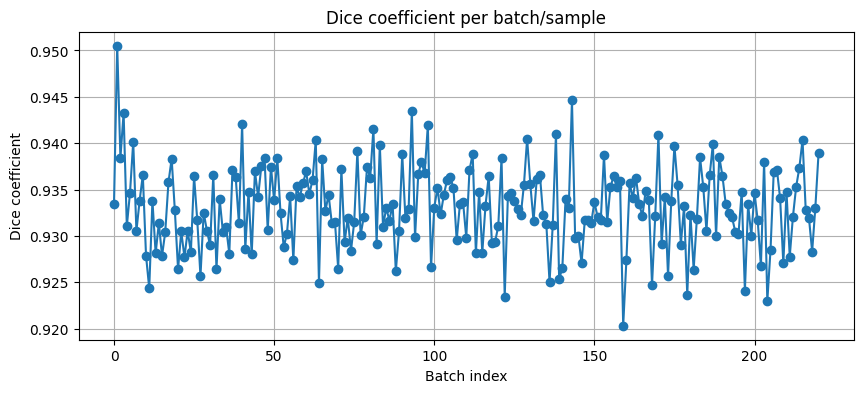

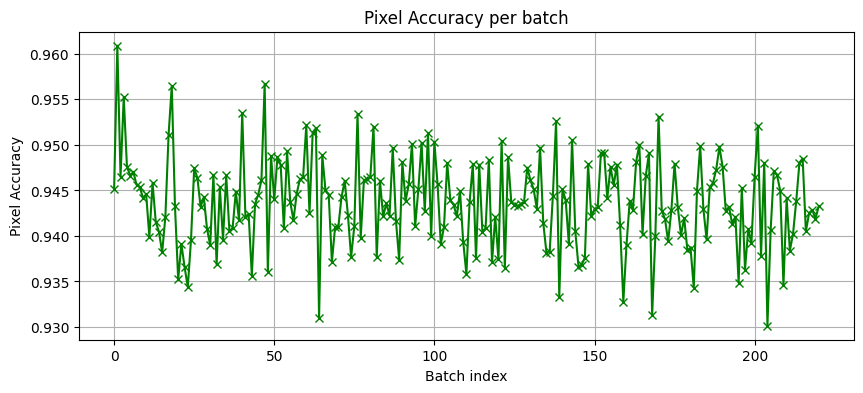

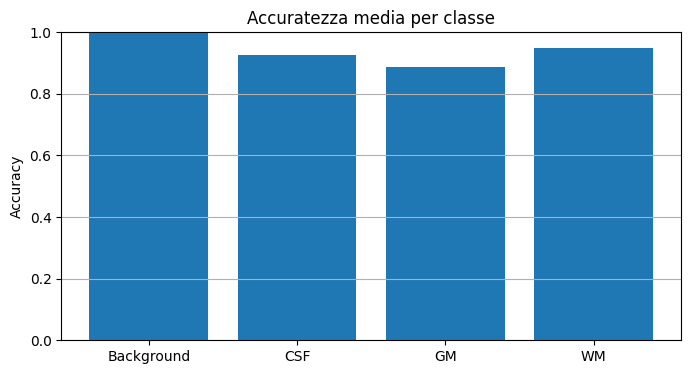

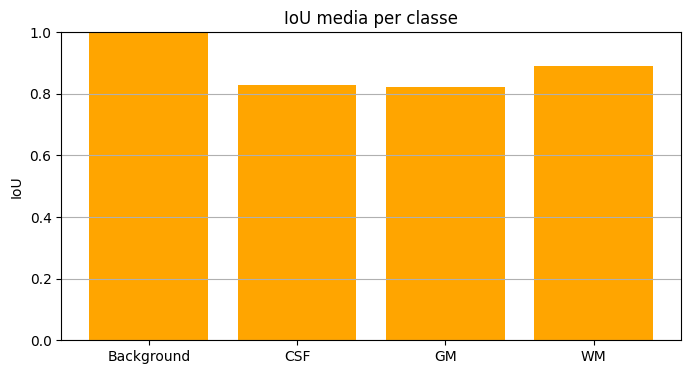

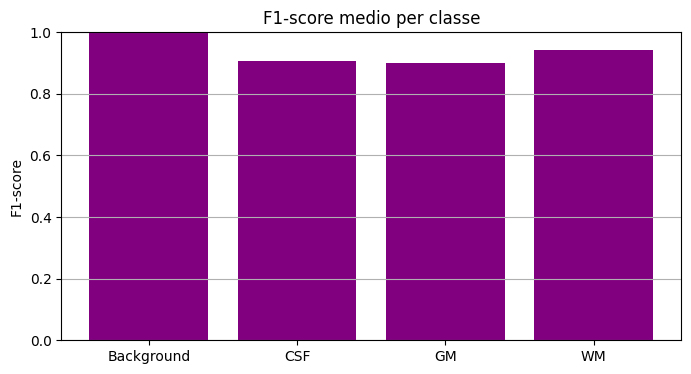

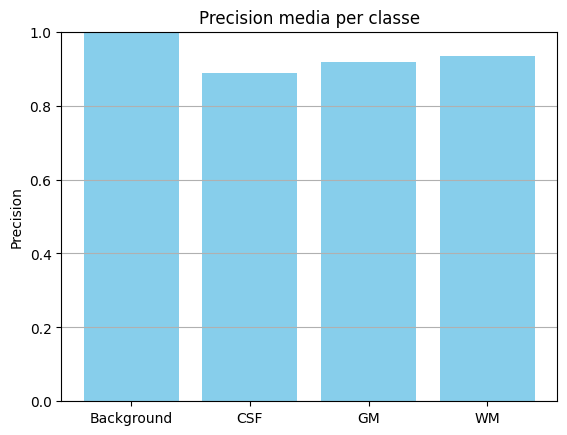

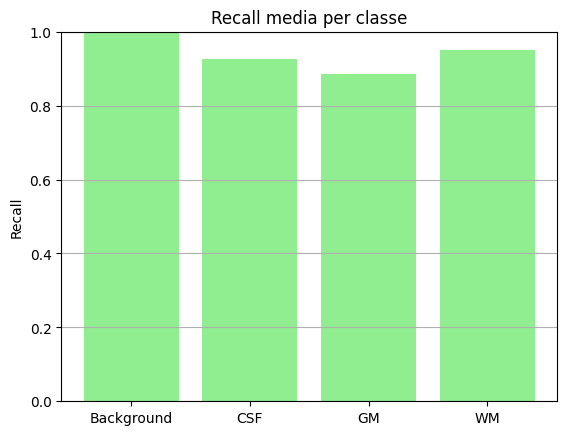

In [357]:
# VISUALIZZAZIONE DI GRAFICI DELLE METRICHE
# Calcola le medie finali
results_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_metrics.pkl'
with open(results_path, 'rb') as f:
    loaded_results = pickle.load(f)

ds_per_class= loaded_results["dice_per_class"]
ds = loaded_results["dice_scores"]
pa = loaded_results["pixel_accuracies"]
ca = loaded_results["class_accuracies"]
ious = loaded_results["ious_per_class"]
pl = loaded_results["precisions"]
recalls = loaded_results["recalls"]
f1s = loaded_results["f1_scores"]

mean_dice = np.mean(ds)
mean_pixel_acc = np.mean(pa)
mean_class_acc = np.mean(ca)
mean_iou = np.mean([np.mean(iou) for iou in ious])
mean_precision = np.mean([np.mean(p) for p in pl])
mean_recall = np.mean([np.mean(r) for r in recalls])
mean_f1 = np.mean([np.mean(f1) for f1 in f1s])

print(f"\n===> Global Results:")
print(f"  Dice Score (DSC): {mean_dice:.4f}")
print(f"  Jaccard Index (IoU): {mean_iou:.4f}")
print(f"  Pixel Accuracy: {mean_pixel_acc:.4f}")
print(f"  Class Accuracy: {mean_class_acc:.4f}")
print(f"  Precision: {mean_precision:.4f}")
print(f"  Recall: {mean_recall:.4f}")
print(f"  F1 Score: {mean_f1:.4f}")


ds_array=np.array(ds_per_class)
mean_dice_per_class = np.mean(ds_array,axis=0)
# Dice score medio per ogni batch
plt.figure(figsize=(10,4))
plt.plot(ds, marker='o')
plt.title("Dice coefficient per batch/sample")
plt.xlabel("Batch index")
plt.ylabel("Dice coefficient")
plt.grid(True)
plt.show()


# Accuratezza pixel-wise per ogni batch
plt.figure(figsize=(10,4))
plt.plot(pa, marker='x', color='green')
plt.title("Pixel Accuracy per batch")
plt.xlabel("Batch index")
plt.ylabel("Pixel Accuracy")
plt.grid(True)
plt.show()

# Media dell’accuratezza per ciascuna classe
ca = np.array(ca)
mean_ca_per_class = np.mean(ca, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(mean_ca_per_class)), mean_ca_per_class)
plt.xticks(range(len(mean_ca_per_class)), [class_names_seg[i] for i in range(len(mean_ca_per_class))])
plt.title("Accuratezza media per classe")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()


# Media dell'IoU per classe
iou_array = np.array(ious)
mean_iou_per_class = np.mean(iou_array, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(mean_iou_per_class)), mean_iou_per_class, color='orange')
plt.xticks(range(len(mean_iou_per_class)), [class_names_seg[i] for i in range(len(mean_iou_per_class))])
plt.title("IoU media per classe")
plt.ylabel("IoU")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

#Media dell'F1 score per classe
f1_array = np.array(f1s)
mean_f1_per_class = np.mean(f1_array, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(mean_f1_per_class)), mean_f1_per_class, color='purple')
plt.xticks(range(len(mean_f1_per_class)), [class_names_seg[i] for i in range(len(mean_f1_per_class))])
plt.title("F1-score medio per classe")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

# Media della Precision e Recall per classe
precision_array = np.array(pl)
recall_array = np.array(recalls)
mean_precision = precision_array.mean(axis=0)
mean_recall = recall_array.mean(axis=0)

classes = [class_names_seg[i] for i in range(mean_precision.shape[0])]

plt.bar(classes, mean_precision, color='skyblue')
plt.title("Precision media per classe")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

plt.bar(classes, mean_recall, color='lightgreen')
plt.title("Recall media per classe")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [122]:
# Estrazione della cartella predizioni da Drive

zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/predictions.zip"
extract_folder = "/content/Alzheimer-detection-project/predizioni"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_folder)
print("File estratti:", os.listdir(extract_folder))

File estratti: ['train', 'test', 'val']


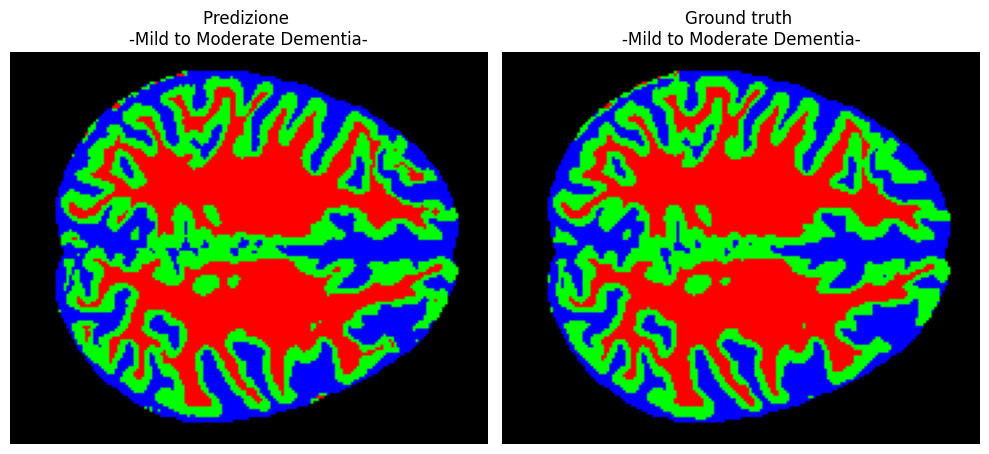

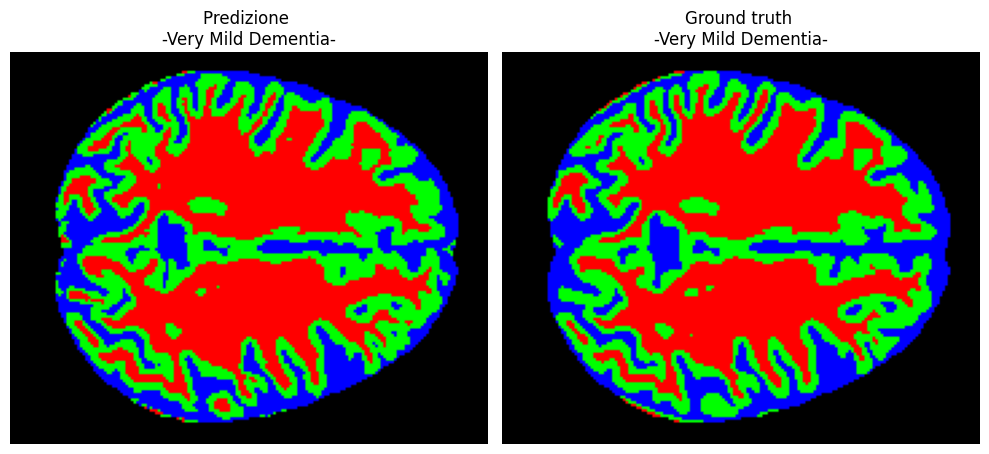

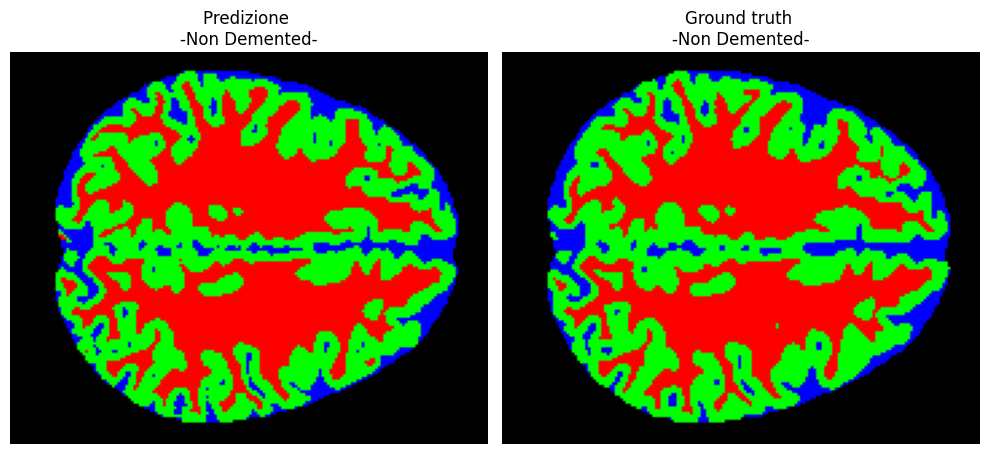

In [358]:
# Visualizzazione affiancata di ground truth e predizione

pred_path= "/content/Alzheimer-detection-project/predizioni/test"
for category in categories:
  category_path_target = os.path.join(oasis1_path, category)
  category_path_pred = os.path.join(pred_path, category)
  mri_segmented_path_target = os.path.join(category_path_target, 'mri segmented')
  mri_segmented_path_pred = os.path.join(category_path_pred, 'mri segmented')
  folders=os.listdir(mri_segmented_path_pred)
  random_folder = random.choice(folders)

  patient_path_pred= os.path.join(mri_segmented_path_pred, random_folder)
  patient_path_target= os.path.join(mri_segmented_path_target, random_folder)

  img_path = os.path.join(patient_path_pred, 'slice_110_pred.png')
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_target, 'slice_110.npy')
  img_seg_onehot = np.load(img_seg_path)
  target_colored = colorize_prediction(img_seg_onehot)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img)
  axes[0].set_title(f"Predizione \n-{category}-")
  axes[0].axis('off')

  axes[1].imshow(target_colored)
  axes[1].set_title(f"Ground truth \n-{category}-")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()

# **CONFRONTO CON ALTRI MODELLI DI SEGMENTAZIONE**

In [364]:
from pandas.plotting import table
data = [
    ("Zhang ", "IBSR", "CSF", 83.5, "DSC"),("Zhang ", "IBSR", "GM", 85.2, "DSC"),("Zhang ", "IBSR", "WM", 86.4, "DSC"),
    ("Brebisson", "MICCAI", "CSF", 72.5, "DSC"),("Brebisson", "MICCAI", "GM", 72.5, "DSC"),("Brebisson", "MICCAI", "WM", 72.5, "DSC"),
    ("Moeskops", "MICCAI", "CSF", 73.5, "DSC"),("Moeskops", "MICCAI", "GM", 73.5, "DSC"),("Moeskops", "MICCAI", "WM", 73.5, "DSC"),
    ("Bao", "IBSR", "CSF", 82.2, "DSC"),("Bao", "IBSR", "GM", 85.0, "DSC"),("Bao", "IBSR", "WM", 82.2, "DSC"),
    ("Dong", "IBSR", "CSF", 85.5, "DSC"),("Dong", "IBSR", "GM", 87.3, "DSC"),("Dong", "IBSR", "WM", 88.7, "DSC"),
    ("Khagi", "OASIS", "CSF", 72.2, "DSC"),("Khagi", "OASIS", "WM", 74.6, "DSC"),("Khagi", "OASIS", "GM", 81.9, "DSC"),
    ("Shakeri", "IBSR", "CSF", 82.4, "DSC"),("Shakeri", "IBSR", "GM", 82.4, "DSC"),("Shakeri", "IBSR", "WM", 82.4, "DSC"),
    ("Raghav", "MICCAI", "CSF", 74.3, "DSC"),("Raghav", "MICCAI", "GM", 74.3, "DSC"),("Raghav", "MICCAI", "WM", 74.3, "DSC"),
    ("Raghav", "IBSR", "CSF", 84.4, "DSC"),("Raghav", "IBSR", "GM", 84.4, "DSC"),("Raghav", "IBSR", "WM", 84.4, "DSC"),
    ("Milletari", "IBSR", "CSF", 77.0, "DSC"),("Milletari", "IBSR", "GM", 77.0, "DSC"),("Milletari", "IBSR", "WM", 77.0, "DSC"),
    ("Dolz", "IBSR", "CSF", 90.0, "DSC"),("Dolz", "IBSR", "GM", 90.0, "DSC"),("Dolz", "IBSR", "WM", 90.0, "DSC"),
    ("Wachinger", "MICCAI", "CSF", 90.6, "DSC"),("Wachinger", "MICCAI", "GM", 90.6, "DSC"),("Wachinger", "MICCAI", "WM", 90.6, "DSC"),
    ("Chen", "IBSR", "CSF", 93.6, "DSC"),("Chen", "IBSR", "GM", 94.8, "DSC"),("Chen", "IBSR", "WM", 97.5, "DSC"),
    ("Me", "OASIS", "CSF", round(mean_dice_per_class[1] * 100, 1), "DSC"),
    ("Me", "OASIS", "GM", round(mean_dice_per_class[2] * 100, 1), "DSC"),
    ("Me", "OASIS", "WM", round(mean_dice_per_class[3] * 100, 1), "DSC"),
]

data2=[    ("Me", "OASIS", "CSF",round(mean_iou_per_class[1] * 100, 1) , "JI"),
    ("Me", "OASIS", "GM",round(mean_iou_per_class[2] * 100, 1) , "JI"),
    ("Me", "OASIS", "WM",round(mean_iou_per_class[3] * 100, 1), "JI"),
    ("Zhenglun", "IBSR", "CSF", 94.3, "JI"),("Zhenglun", "IBSR", "GM", 90.2, "JI"),("Zhenglun", "IBSR", "WM", 91.4, "JI"),
    ("Khagi", "OASIS", "GM", 73.0, "JI"),("Khagi", "OASIS", "WM", 85.0, "JI"),    ("Khagi", "OASIS", "CSF", 74.0, "JI"),
]

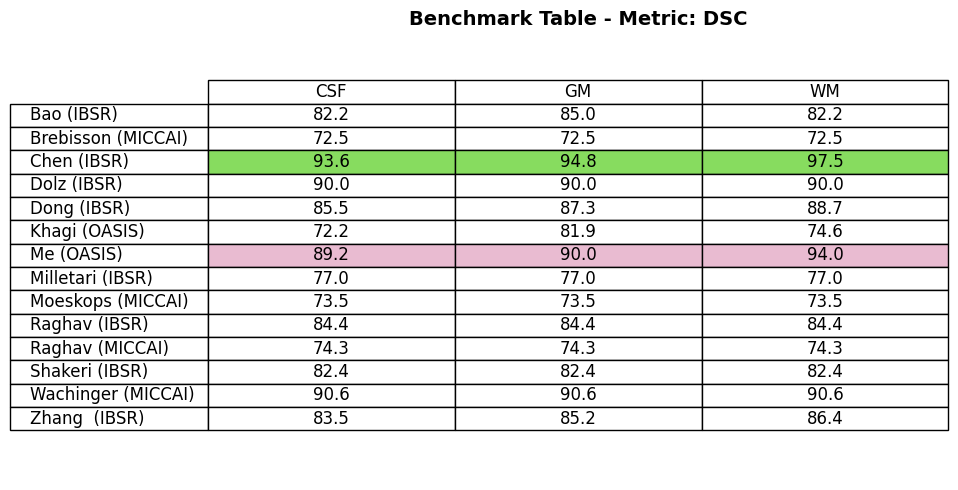

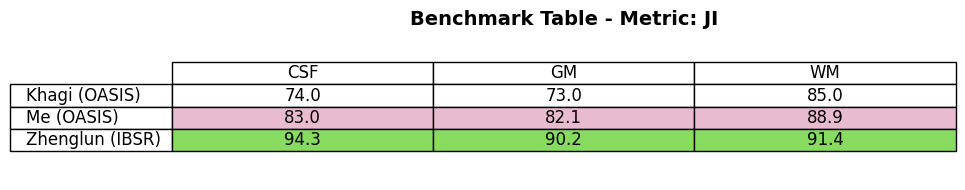

In [366]:
me_color = "#E9BBD1"
highlight_color="#87DC5F"

dataframe_becnkmark = pd.DataFrame(data, columns=["Author", "Dataset", "Tissue", "Value", "Metric"])
metrics = ", ".join(dataframe_becnkmark["Metric"].unique())
title = f"Benchmark Table - Metric: {metrics}"
dataframe_becnkmark["ColName"] = dataframe_becnkmark["Tissue"]
dataframe_becnkmark["AuthorDataset"] = dataframe_becnkmark["Author"] + " (" + dataframe_becnkmark["Dataset"] + ")"

dataframe_becnkmark = dataframe_becnkmark.pivot_table(index="AuthorDataset", columns="ColName", values="Value")

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(title, fontsize=14, weight='bold', pad=4)
ax.axis('off')

tbl = table(ax, dataframe_becnkmark, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

for col_idx, col in enumerate(dataframe_becnkmark.columns):
    max_value = dataframe_becnkmark[col].max()
    for row_idx, val in enumerate(dataframe_becnkmark[col]):
        cell = tbl.get_celld().get((row_idx + 1, col_idx))
        if cell is not None:
            author_metric = dataframe_becnkmark.index[row_idx]
            if author_metric.startswith("Me"):
                cell.set_facecolor(me_color)
            if pd.notna(val) and val == max_value:
                cell.set_facecolor(highlight_color)

plt.tight_layout()
plt.savefig("tabella.png", dpi=300)
plt.show()



dataframe_becnkmark2 = pd.DataFrame(data2, columns=["Author", "Dataset", "Tissue", "Value", "Metric"])
metrics = ", ".join(dataframe_becnkmark2["Metric"].unique())
title = f"Benchmark Table - Metric: {metrics}"
dataframe_becnkmark2["ColName"] =  dataframe_becnkmark2["Tissue"]
dataframe_becnkmark2["AuthorMetric"] = dataframe_becnkmark2["Author"] + " (" + dataframe_becnkmark2["Dataset"] + ")"

dataframe_becnkmark2 = dataframe_becnkmark2.pivot_table(index="AuthorMetric", columns="ColName", values="Value")
dataframe_becnkmark2.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(10, 2))
ax.set_title(title, fontsize=14, weight='bold')
ax.axis('off')

tbl = table(ax, dataframe_becnkmark2, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.4)


for col_idx, col in enumerate(dataframe_becnkmark2.columns):
    max_value = dataframe_becnkmark2[col].max()
    for row_idx, val in enumerate(dataframe_becnkmark2[col]):
        cell = tbl.get_celld().get((row_idx + 1, col_idx))
        if cell is not None:
            author_metric = dataframe_becnkmark2.index[row_idx]
            if author_metric.startswith("Me"):
                cell.set_facecolor(me_color)
            if pd.notna(val) and val == max_value:
                cell.set_facecolor(highlight_color)

plt.tight_layout()
plt.savefig("tabella.png", dpi=300)
plt.show()

# **CLASSIFICAZIONE**

### *OPERAZIONI PRELIMINARI*

In [123]:
# Creazione dataframe per la classificazione

# MAPPA DA COLORI A CLASSI
color_to_class = {
    (0, 0, 255): "csf",
    (0, 255, 0): "gm",
    (255, 0, 0): "wm"
  }
path = "/content/drive/MyDrive/Alzheimer-detection-project/dataframe.pkl"
if not os.path.exists(path):
  my_data = []
  oasis1_path='/content/Alzheimer-detection-project/predizioni'
  div= [d for d in os.listdir(oasis1_path) if os.path.isdir(os.path.join(oasis1_path, d))]
  for division in div:
    division_path = os.path.join(oasis1_path, division)
    categories_folders = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
    for diagnosis in categories_folders:
      segmented_path = os.path.join(division_path, diagnosis, "mri segmented")
      patients = [p for p in os.listdir(segmented_path) if os.path.isdir(os.path.join(segmented_path, p))]

      for patient_id in patients:
        patient_folder = os.path.join(segmented_path, patient_id)
        volume_counts = {"wm": 0, "gm": 0, "csf": 0}

        for i in os.listdir(patient_folder):
          img_path = os.path.join(patient_folder, i)
          img = np.array(Image.open(img_path))
          for color, cls in color_to_class.items():
            mask = np.all(img == color, axis=-1)
            volume_counts[cls] += np.sum(mask)

        # volume cerebrale complessivo segmentato
        total_volume = volume_counts["wm"] + volume_counts["gm"] + volume_counts["csf"]
        # rapporti rispetto al volume cerebrale totale
        wm_ratio= volume_counts["wm"] / (total_volume + 1e-6)
        gm_ratio = volume_counts["gm"] / (total_volume + 1e-6)
        csf_ratio = volume_counts["csf"] / (total_volume + 1e-6)
        # rapporti tra parametri
        gm_to_csf_ratio = volume_counts["gm"] / (volume_counts["csf"] + 1e-6)
        wm_to_gm_ratio = volume_counts["wm"] / (volume_counts["gm"] + 1e-6)
        csf_to_wm_ratio = volume_counts["csf"] / (volume_counts["wm"] + 1e-6)
        csf_to_gm_ratio = volume_counts["csf"] / (volume_counts["gm"] + 1e-6)
        # logaritmi
        log_wm = np.log1p(volume_counts["wm"])
        log_gm = np.log1p(volume_counts["gm"])
        log_csf = np.log1p(volume_counts["csf"])


        my_data.append({
            "patient_id": patient_id,
            "diagnosis": diagnosis,
            "volume_wm": volume_counts["wm"],
            "volume_gm": volume_counts["gm"],
            "volume_csf": volume_counts["csf"],
            "volume_totale": total_volume,
            "wm_ratio": wm_ratio,
            "gm_ratio": gm_ratio,
            "csf_ratio": csf_ratio,
            "gm_to_csf_ratio": gm_to_csf_ratio,
            "wm_to_gm_ratio": wm_to_gm_ratio,
            "csf_to_wm_ratio": csf_to_wm_ratio,
            "csf_to_gm_ratio":csf_to_gm_ratio,
            "log_wm": log_wm,
            "log_gm":log_gm,
            "log_csf":log_csf
          })

  df = pd.DataFrame(my_data)
  df["patient_id"] = df["patient_id"].str.replace(" seg", "", regex=False)
else:
  print("lo scarico da drive")
  with open(path, "rb") as f:
    df = pickle.load(f)

lo scarico da drive


In [124]:
# Preparazione di feature e etichette normalizzate per il training, validation e test set.


df_train = df[df["patient_id"].isin(train_ids)].reset_index(drop=True)
df_test = df[df["patient_id"].isin(test_ids)].reset_index(drop=True)
df_validation = df[df["patient_id"].isin(val_ids)].reset_index(drop=True)

features = [
    "volume_wm", "volume_gm", "volume_csf", "volume_totale",
    "wm_ratio", "gm_ratio", "csf_ratio",
    "gm_to_csf_ratio", "wm_to_gm_ratio", "csf_to_wm_ratio", "csf_to_gm_ratio",
    "log_wm", "log_gm", "log_csf"
]
features_train = df_train[features].values
features_test = df_test[features].values
features_val = df_validation[features].values
mean = features_train.mean(axis=0)
std = features_train.std(axis=0)
X_train = (features_train - mean) / (std + 1e-6)
X_test = (features_test - mean) / (std + 1e-6)
X_val= (features_val - mean) / (std + 1e-6)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["diagnosis"]).astype(np.int64)
y_test = label_encoder.transform(df_test["diagnosis"]).astype(np.int64)
y_val=  label_encoder.transform(df_validation["diagnosis"]).astype(np.int64)
n_classes = len(label_encoder.classes_)

y_train_onehot = onehot_encoding(y_train, 3)
y_test_onehot = onehot_encoding(y_test, 3)
y_val_onehot=onehot_encoding(y_val, 3)

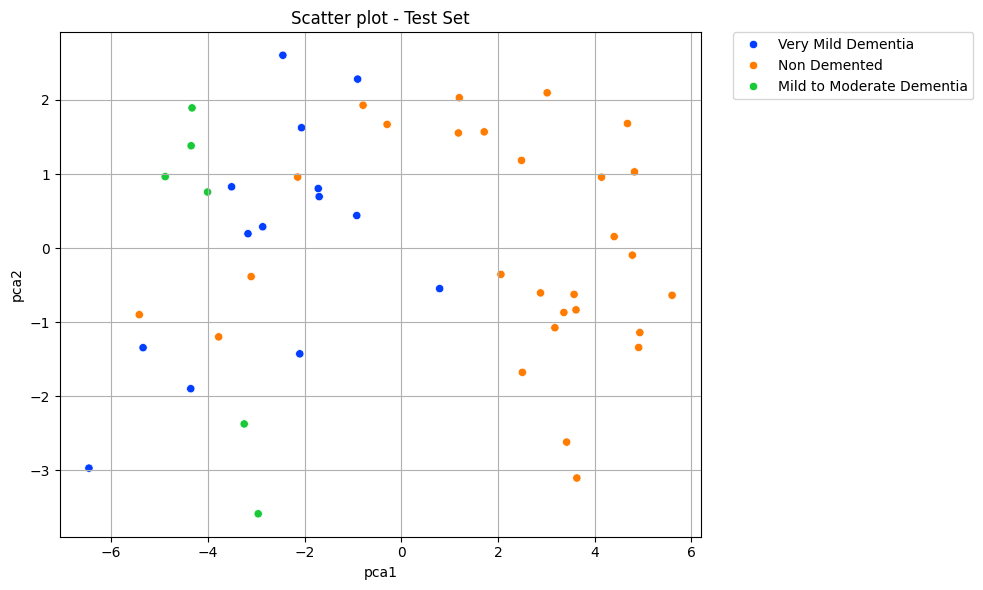

In [125]:
# Visualizzazione della distribuzione del Test set

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

df_viz = df_test.copy()
df_viz["pca1"] = X_pca[:, 0]
df_viz["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_viz, x="pca1", y="pca2", hue="diagnosis", palette="bright")
plt.title("Scatter plot - Test Set")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [126]:
# Inizializzazione parametri
n_samples, n_features = X_train.shape
W = np.random.randn(n_features, 3) * 0.01
b = np.zeros((1, 3))
learning_rate = 0.001
n_epochs = 10000

# Pesi dal numero di pazienti per classe
counts = np.array([30, 136, 70])
weights = 1.0 / counts

### *METRICHE PER LA CLASSIFICAZIONE*

In [127]:
# Metriche per la classificazione

def precision_per_class(y_pred, y_true_onehot, epsilon=1e-7):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  n_classes = y_true_onehot.shape[1]
  precisions = []

  for c in range(n_classes):
    tp = np.sum((y_pred_labels == c) & (y_true_labels == c))
    fp = np.sum((y_pred_labels == c) & (y_true_labels != c))
    precision = tp / (tp + fp + epsilon)
    precisions.append(precision)
  return precisions

def accuracy_classifier(y_pred, y_true_onehot):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  return np.mean(y_pred_labels == y_true_labels)

def recall_per_class(y_pred, y_true_onehot, epsilon=1e-7):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  n_classes = y_true_onehot.shape[1]
  recalls = []

  for c in range(n_classes):
    tp = np.sum((y_pred_labels == c) & (y_true_labels == c))
    fn = np.sum((y_pred_labels != c) & (y_true_labels == c))
    recall = tp / (tp + fn + epsilon)
    recalls.append(recall)
  return recalls

def f1_score_per_class(y_pred, y_true_onehot, epsilon=1e-7):
  precisions = precision_per_class(y_pred, y_true_onehot, epsilon)
  recalls = recall_per_class(y_pred, y_true_onehot, epsilon)
  f1s = []

  for p, r in zip(precisions, recalls):
    f1 = 2 * p * r / (p + r + epsilon)
    f1s.append(f1)
  return f1s

def confusion_matrix_class(y_pred, y_true_onehot):
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true_onehot, axis=1)
  n_classes = y_true_onehot.shape[1]
  cm = np.zeros((n_classes, n_classes), dtype=int)
  for t, p in zip(y_true_labels, y_pred_labels):
    cm[t, p] += 1
  return cm

## **CLASSIFICATORE LINEARE**

In [128]:
# Funzioni ausiliarie

def softmax_classifier(z):
  exp = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp / np.sum(exp, axis=1, keepdims=True)

def weighted_cross_entropy_loss_classifier(y_pred, y_true, weights):
  loss = - np.sum(weights * y_true * np.log(y_pred + 1e-12), axis=1)
  return np.mean(loss)

In [129]:
# Funzione di training per il classificatore lineare

def train_classifier(X_train, y_train_onehot, W, b, n_epochs, lr, weights,
                          beta1=0.9, beta2=0.999):
  mW, vW = np.zeros_like(W), np.zeros_like(W)
  mb, vb = np.zeros_like(b), np.zeros_like(b)

  for epoch in range(1, n_epochs + 1):
    if epoch % 1000 == 0:
      lr *= 0.5
    z = np.dot(X_train, W) + b
    y_pred = softmax_classifier(z)
    loss = weighted_cross_entropy_loss_classifier(y_pred, y_train_onehot, weights)

    sample_weights = np.sum(weights * y_train_onehot, axis=1, keepdims=True)
    n_samples = X_train.shape[0]
    dz = (y_pred - y_train_onehot) * sample_weights / n_samples
    dW = np.dot(X_train.T, dz)
    db = np.sum(dz, axis=0, keepdims=True)

    mW = beta1 * mW + (1 - beta1) * dW
    vW = beta2 * vW + (1 - beta2) * (dW ** 2)
    mb = beta1 * mb + (1 - beta1) * db
    vb = beta2 * vb + (1 - beta2) * (db ** 2)
    mW_corr = mW / (1 - beta1 ** epoch)
    vW_corr = vW / (1 - beta2 ** epoch)
    mb_corr = mb / (1 - beta1 ** epoch)
    vb_corr = vb / (1 - beta2 ** epoch)
    W -= lr * mW_corr / (np.sqrt(vW_corr) + 1e-8)
    b -= lr * mb_corr / (np.sqrt(vb_corr) + 1e-8)

    if (epoch % 1000 == 0 or epoch == n_epochs or epoch==1):
      print(f"Epoch {epoch} | Loss: {loss:.4f} | LR: {lr:.6f}")

  return W, b

In [130]:
# Training del classificatore

W, b =  train_classifier(X_train, y_train_onehot, W, b,
                        n_epochs, learning_rate, weights)

# Test classificatore lineare

z_test = np.dot(X_test, W) + b
y_test_pred = softmax_classifier(z_test)

acc_test = accuracy_classifier(y_test_pred, y_test_onehot)
prec_test = precision_per_class(y_test_pred, y_test_onehot)
rec_test = recall_per_class(y_test_pred, y_test_onehot)
f1_test = f1_score_per_class(y_test_pred, y_test_onehot)
conf_matrix = confusion_matrix_class(y_test_pred, y_test_onehot)
class_names = label_encoder.classes_

print(f"\nTest Accuracy: {acc_test:.4f}")
for i, (prec, rec, f1) in enumerate(zip(prec_test, rec_test, f1_test)):
  print(f"Classe {i} ({class_names[i]}):")
  print(f"  Precision: {prec:.4f}")
  print(f"  Recall:    {rec:.4f}")
  print(f"  F1-score:  {f1:.4f}\n")

table = conf_matrix.tolist() if hasattr(conf_matrix, 'tolist') else list(conf_matrix)
class_names = list(class_names)
print(tabulate(table, headers=class_names, showindex=class_names, tablefmt='fancy_grid'))

Epoch 1 | Loss: 0.0136 | LR: 0.001000
Epoch 1000 | Loss: 0.0086 | LR: 0.000500
Epoch 2000 | Loss: 0.0086 | LR: 0.000250
Epoch 3000 | Loss: 0.0085 | LR: 0.000125
Epoch 4000 | Loss: 0.0085 | LR: 0.000063
Epoch 5000 | Loss: 0.0085 | LR: 0.000031
Epoch 6000 | Loss: 0.0085 | LR: 0.000016
Epoch 7000 | Loss: 0.0085 | LR: 0.000008
Epoch 8000 | Loss: 0.0085 | LR: 0.000004
Epoch 9000 | Loss: 0.0085 | LR: 0.000002
Epoch 10000 | Loss: 0.0085 | LR: 0.000001

Test Accuracy: 0.7292
Classe 0 (Mild to Moderate Dementia):
  Precision: 0.4286
  Recall:    0.5000
  F1-score:  0.4615

Classe 1 (Non Demented):
  Precision: 0.9565
  Recall:    0.7857
  F1-score:  0.8627

Classe 2 (Very Mild Dementia):
  Precision: 0.5556
  Recall:    0.7143
  F1-score:  0.6250

╒═══════════════════════════╤═════════════════════════════╤════════════════╤══════════════════════╕
│                           │   Mild to Moderate Dementia │   Non Demented │   Very Mild Dementia │
╞═══════════════════════════╪══════════════════════

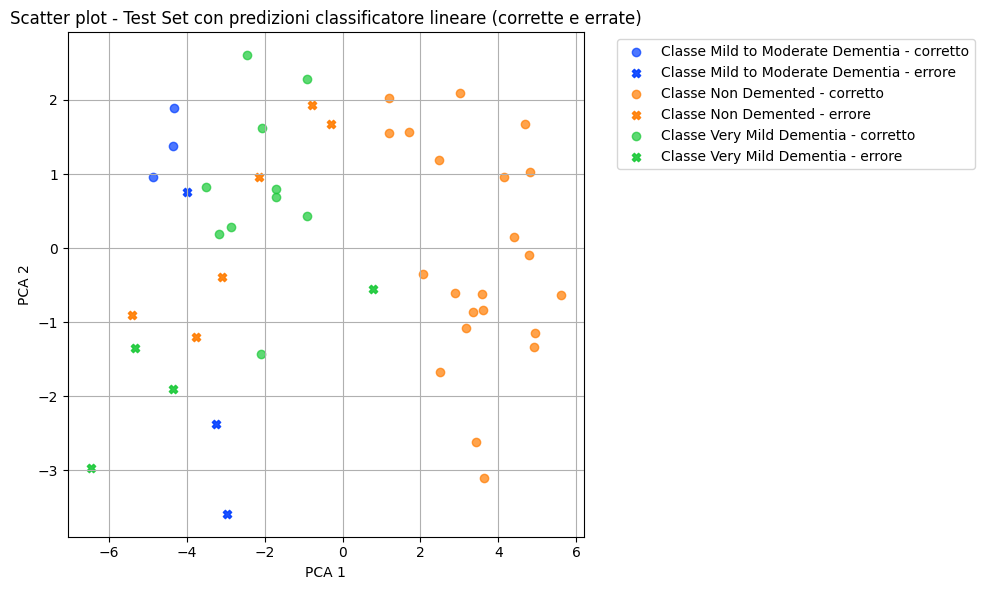

In [131]:
# Visualizzazione grafico delle performance

if y_test_pred.ndim > 1 and y_test_pred.shape[1] > 1:
  y_pred_labels = np.argmax(y_test_pred, axis=1)
else:
  y_pred_labels = y_test_pred

df_viz = df_test.copy()
df_viz["pca1"] = X_pca[:, 0]
df_viz["pca2"] = X_pca[:, 1]
df_viz["diagnosis_encoded"] = label_encoder.transform(df_viz["diagnosis"])
df_viz["pred_encoded"] = y_pred_labels
df_viz["correct"] = (df_viz["diagnosis_encoded"] == df_viz["pred_encoded"])


plt.figure(figsize=(10,6))
palette = sns.color_palette("bright", n_colors=len(class_names))
for cls in range(len(class_names)):
  subset = df_viz[df_viz["diagnosis_encoded"] == cls]
  plt.scatter(subset[subset["correct"]]["pca1"], subset[subset["correct"]]["pca2"],
                label=f"Classe {class_names[cls]} - corretto",
                color=palette[cls], marker='o', alpha=0.7)
  plt.scatter(subset[~subset["correct"]]["pca1"], subset[~subset["correct"]]["pca2"],
                label=f"Classe {class_names[cls]} - errore",
                color=palette[cls], marker='X', alpha=0.9)

plt.title("Scatter plot - Test Set con predizioni classificatore lineare (corrette e errate)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## **KNN**

In [132]:
# Funzioni per classificazione KNNN

def knn_predict(X_train, y_train, x_test, k, class_weights):
  dist = np.linalg.norm(X_train - x_test, axis=1)
  idxs = np.argsort(dist)[:k]
  nearest_labels = y_train[idxs]
  nearest_dists = dist[idxs]

  weights = 1 / (nearest_dists + 1e-5)
  class_votes = {}
  for label, w in zip(nearest_labels, weights):
    class_votes[label] = class_votes.get(label, 0) + w * class_weights[label]

  return max(class_votes, key=class_votes.get)

def knn_predict_all(X_train, y_train, X_test, k, class_weights):
  return np.array([knn_predict(X_train, y_train, x_test, k,class_weights) for x_test in X_test])

In [133]:
# Test classificazione con KNN

k = 3
y_pred = knn_predict_all(X_train, y_train, X_test, k,weights)
y_pred_onehot = onehot_encoding(y_pred, 3)

acc = accuracy_classifier(y_pred_onehot, y_test_onehot)
prec = precision_per_class(y_pred_onehot, y_test_onehot)
rec = recall_per_class(y_pred_onehot, y_test_onehot)
f1 = f1_score_per_class(y_pred_onehot, y_test_onehot)
cm = confusion_matrix_class(y_pred_onehot, y_test_onehot)

print(f"\nTest Accuracy: {acc:.4f}")
for i, (p, r, f) in enumerate(zip(prec, rec, f1)):
    print(f"Classe {i} ({class_names[i]}):")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall:    {r:.4f}")
    print(f"  F1-score:  {f:.4f}\n")

table = cm.tolist() if hasattr(cm, 'tolist') else list(cm)
print(tabulate(table, headers=class_names, showindex=class_names, tablefmt='fancy_grid'))


Test Accuracy: 0.7708
Classe 0 (Mild to Moderate Dementia):
  Precision: 0.5556
  Recall:    0.8333
  F1-score:  0.6667

Classe 1 (Non Demented):
  Precision: 0.9565
  Recall:    0.7857
  F1-score:  0.8627

Classe 2 (Very Mild Dementia):
  Precision: 0.6250
  Recall:    0.7143
  F1-score:  0.6667

╒═══════════════════════════╤═════════════════════════════╤════════════════╤══════════════════════╕
│                           │   Mild to Moderate Dementia │   Non Demented │   Very Mild Dementia │
╞═══════════════════════════╪═════════════════════════════╪════════════════╪══════════════════════╡
│ Mild to Moderate Dementia │                           5 │              0 │                    1 │
├───────────────────────────┼─────────────────────────────┼────────────────┼──────────────────────┤
│ Non Demented              │                           1 │             22 │                    5 │
├───────────────────────────┼─────────────────────────────┼────────────────┼──────────────────────┤


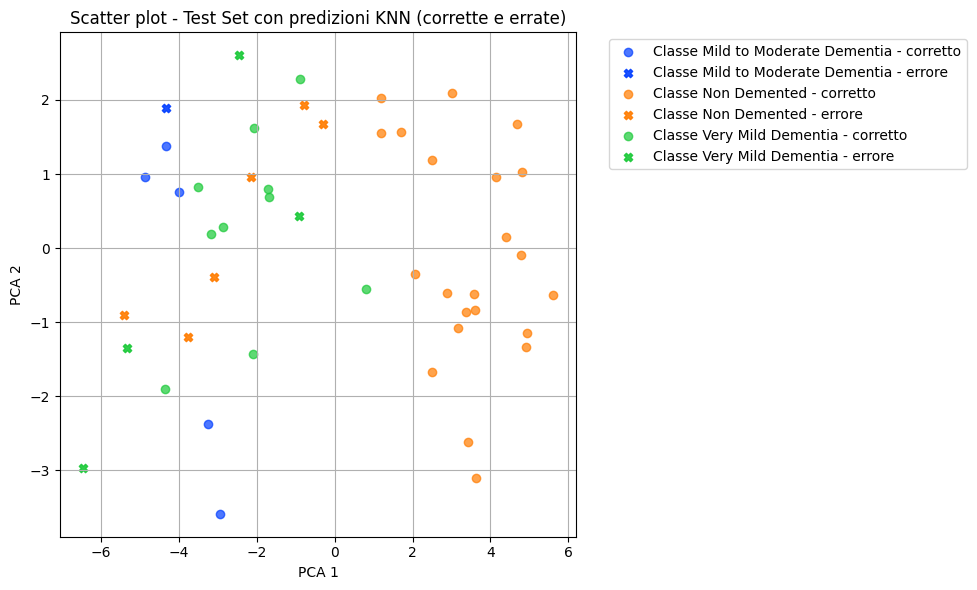

In [134]:
# Visualizzazione grafico delle performance

if y_pred_onehot.ndim > 1 and y_pred_onehot.shape[1] > 1:
  y_pred_labels = np.argmax(y_pred_onehot, axis=1)
else:
  y_pred_labels = y_pred

df_viz["pca1"] = X_pca[:, 0]
df_viz["pca2"] = X_pca[:, 1]
df_viz["knn_pred"] = y_pred_labels
df_viz["diagnosis_encoded"] = label_encoder.transform(df_viz["diagnosis"])
df_viz["correct"] = (df_viz["diagnosis_encoded"] == df_viz["knn_pred"])

plt.figure(figsize=(10,6))

palette = sns.color_palette("bright", n_colors=n_classes)
for cls in range(n_classes):
  subset = df_viz[df_viz["diagnosis_encoded"] == cls]
  plt.scatter(subset[subset["correct"]]["pca1"], subset[subset["correct"]]["pca2"],
                label=f"Classe {class_names[cls]} - corretto",
                color=palette[cls], marker='o', alpha=0.7)
  plt.scatter(subset[~subset["correct"]]["pca1"], subset[~subset["correct"]]["pca2"],
                label=f"Classe {class_names[cls]} - errore",
                color=palette[cls], marker='X', alpha=0.9)

plt.title("Scatter plot - Test Set con predizioni KNN (corrette e errate)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# **ANOMALY DETECTION**

## **ISOLATION FOREST**

### *OPERAZIONI PRELIMINARI*

In [135]:
# Creo dataframe di pazienti sani su cui addestrare per rilevare l'anomalia e dataframe di pazienti malati

df_healthy = df[df["diagnosis"] == "Non Demented"]
df_unhealthy = df[df["diagnosis"] != "Non Demented"]
class_names = ["Sano", "Malato"]

In [136]:
# Calcolo/download dei nuovi id di train - test - validation

ae_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ids_if.pkl'
if not os.path.exists(ae_path):
  train_normal, temp_normal = train_test_split(df_healthy, test_size=0.4, random_state=42)
  temp_mixed = pd.concat([temp_normal, df_unhealthy])
  val_set, test_set = train_test_split(temp_mixed, test_size=0.5, random_state=42)

  train_ids = train_normal['patient_id'].tolist()
  val_ids = val_set['patient_id'].tolist()
  test_ids = test_set['patient_id'].tolist()

  print(f"Train (sani): {len(train_ids)}")
  print(f"Validation (misto): {len(val_ids)}")
  print(f"Test (misto): {len(test_ids)}")


else:
  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ids_if.pkl'
  with open(file_path, 'rb') as f:
    train_ids= pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/val_ids_if.pkl'
  with open(file_path, 'rb') as f:
    val_ids = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_ids_if.pkl'
  with open(file_path, 'rb') as f:
    test_ids = pickle.load(f)
  print("li apro da drive")


print("Numero di pazienti di train:", len(train_ids))
print("Numero di pazienti di val:", len(val_ids))
print("Numero di pazienti di test:", len(test_ids))

li apro da drive
Numero di pazienti di train: 81
Numero di pazienti di val: 77
Numero di pazienti di test: 78


In [137]:
# Suddivisione del DataFrame in train - val - test

df_train = df[df["patient_id"].isin(train_ids)].reset_index(drop=True)
df_val = df[df["patient_id"].isin(val_ids)].reset_index(drop=True)
df_test = df[df["patient_id"].isin(test_ids)].reset_index(drop=True)

# Estrazione e normalizzazione delle feature
features_train = df_train[features].values
features_val = df_val[features].values
features_test = df_test[features].values

mean = features_train.mean(axis=0)
std = features_train.std(axis=0)
X_train = (features_train - mean) / (std + 1e-6)
X_val = (features_val - mean) / (std + 1e-6)
X_test = (features_test - mean) / (std + 1e-6)


# encoding delle etichette
label_encoder.fit(df["diagnosis"])
y_train = label_encoder.transform(df_train["diagnosis"]).astype(np.int64)
y_val = label_encoder.transform(df_val["diagnosis"]).astype(np.int64)
y_test = label_encoder.transform(df_test["diagnosis"]).astype(np.int64)

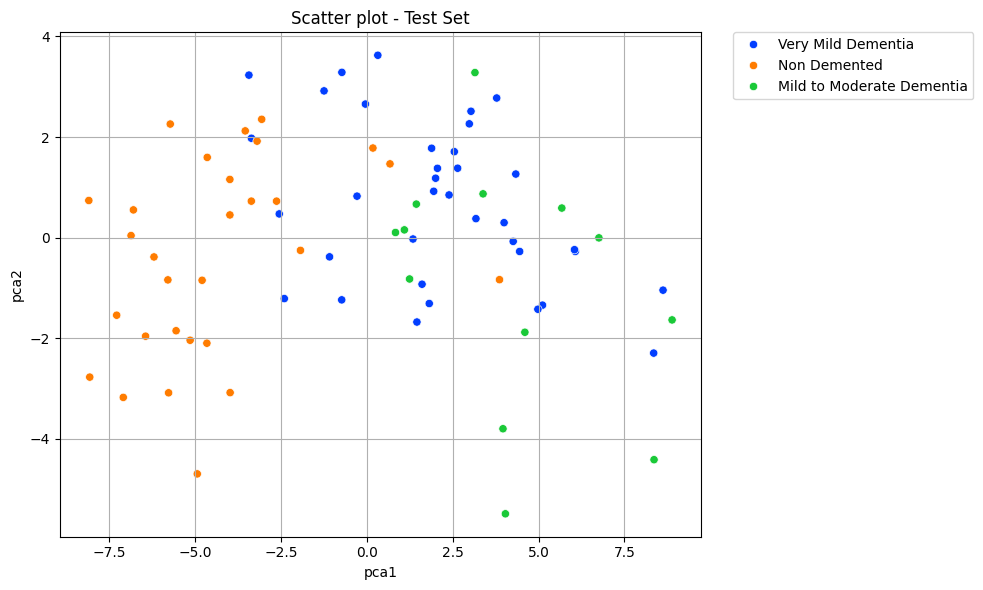

In [138]:
# Visualizzazione della distribuzione del Test set

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

df_viz = df_test.copy()
df_viz["pca1"] = X_pca[:, 0]
df_viz["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_viz, x="pca1", y="pca2", hue="diagnosis", palette="bright")
plt.title("Scatter plot - Test Set")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

### *MODELLO DI ISOLATION FOREST*

   contamination  accuracy  precision    recall
0           0.01  0.363636   1.000000  0.039216
1           0.05  0.610390   0.888889  0.470588
2           0.10  0.662338   0.878788  0.568627
3           0.15  0.714286   0.853659  0.686275
4           0.20  0.727273   0.840909  0.725490
5           0.25  0.753247   0.807692  0.823529
6           0.30  0.792208   0.786885  0.941176
7           0.40  0.805195   0.781250  0.980392


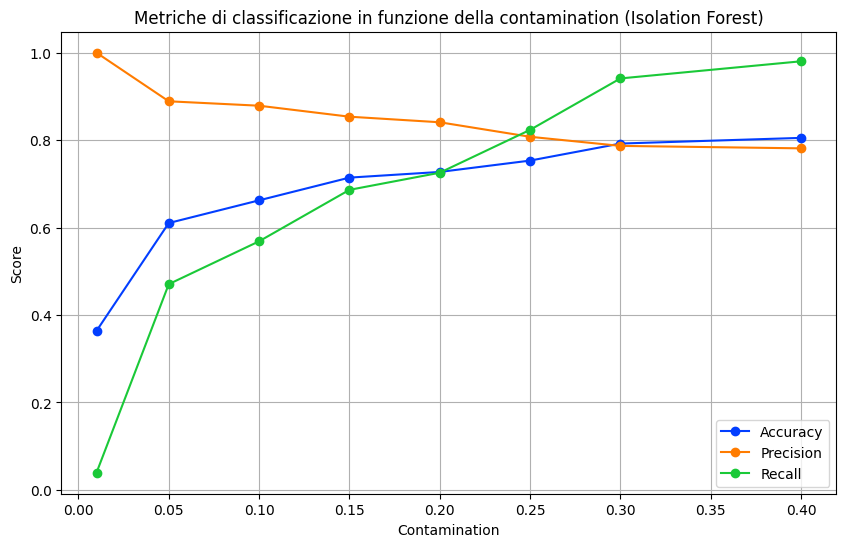

In [139]:
# Scelta del miglior contamination value per Isolation forest (su validation)

contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
results = []
healthy_class_index = list(label_encoder.classes_).index("Non Demented")
y_true = (y_val != healthy_class_index).astype(int)
for c in contamination_values:
  model = IsolationForest(contamination=c, random_state=42)
  model.fit(X_train)
  preds = model.predict(X_val)
  y_pred = (preds == -1).astype(int)

  TP = ((y_true == 1) & (y_pred == 1)).sum()
  TN = ((y_true == 0) & (y_pred == 0)).sum()
  FP = ((y_true == 0) & (y_pred == 1)).sum()
  FN = ((y_true == 1) & (y_pred == 0)).sum()

  accuracy = (TP + TN) / len(y_true)
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0
  recall = TP / (TP + FN) if (TP + FN) > 0 else 0

  results.append((c, accuracy, precision, recall))

df_results = pd.DataFrame(results, columns=["contamination", "accuracy", "precision", "recall"])
print(df_results)

plt.figure(figsize=(10,6))
palette = sns.color_palette("bright", n_colors=3)
plt.plot(df_results["contamination"], df_results["accuracy"], label="Accuracy", marker='o',color=palette[0])
plt.plot(df_results["contamination"], df_results["precision"], label="Precision", marker='o', color=palette[1])
plt.plot(df_results["contamination"], df_results["recall"], label="Recall", marker='o',color=palette[2])
plt.xlabel("Contamination")
plt.ylabel("Score")
plt.title("Metriche di classificazione in funzione della contamination (Isolation Forest)")
plt.legend()
plt.grid(True)
plt.show()

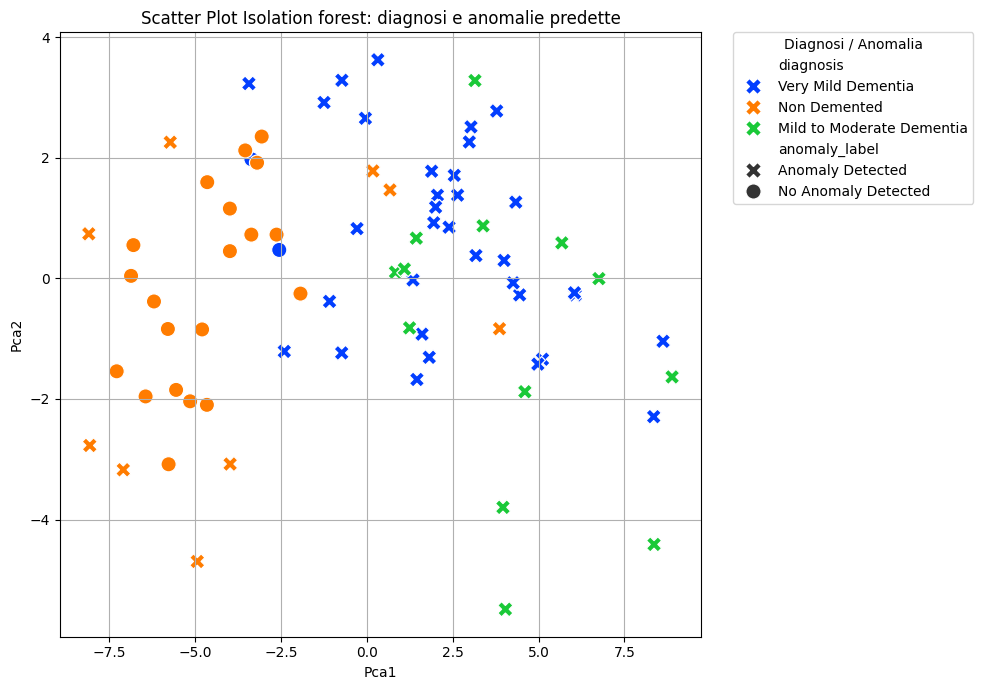

In [140]:
# Addestramento e test di Isolation Forest con visualizzazione grafici

model = IsolationForest(contamination=0.30, random_state=42)
model.fit(X_train)
labels_test = model.predict(X_test)

# Visualizzazione grafico

plt.figure(figsize=(10,7))
df_viz["anomaly"] = labels_test == -1
df_viz["anomaly_label"] = df_viz["anomaly"].map({False: "No Anomaly Detected", True: "Anomaly Detected"})
sns.scatterplot(
    data=df_viz, x="pca1", y="pca2", hue="diagnosis",style="anomaly_label",
    markers={"No Anomaly Detected": "o", "Anomaly Detected": "X"}, s=120, palette="bright")

plt.title("Scatter Plot Isolation forest: diagnosi e anomalie predette")
plt.xlabel("Pca1")
plt.ylabel("Pca2")
plt.grid(True)
plt.legend(title="Diagnosi / Anomalia", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

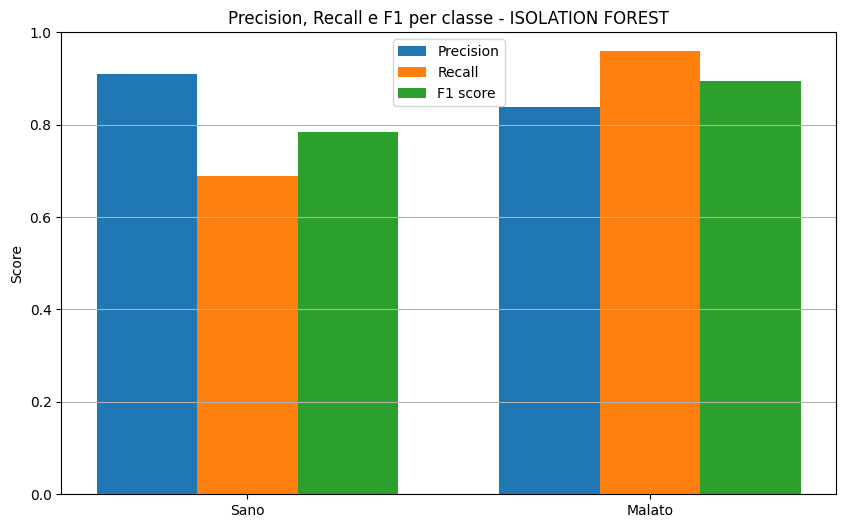


Accuracy: 0.8590

Classe 0: Precision=0.9091, Recall=0.6897, F1=0.7843

Classe 1: Precision=0.8393, Recall=0.9592, F1=0.8952
╒════════╤════════╤══════════╕
│        │   Sano │   Malato │
╞════════╪════════╪══════════╡
│ Sano   │     20 │        9 │
├────────┼────────┼──────────┤
│ Malato │      2 │       47 │
╘════════╧════════╧══════════╛


In [142]:
# Calcolo delle metriche e visualizzazione grafici
n_classes=2
cn = [class_names[i] for i in range(n_classes)]
y_true = (df_test["diagnosis"] != "Non Demented").astype(int)
y_pred = (labels_test == -1).astype(int)
y_true_onehot = onehot_encoding(y_true, n_classes)
y_pred_onehot = onehot_encoding(y_pred, n_classes)

accuracy = accuracy_classifier(y_pred_onehot, y_true_onehot)
precisions = precision_per_class(y_pred_onehot, y_true_onehot)
recalls = recall_per_class(y_pred_onehot, y_true_onehot)
f1s = f1_score_per_class(y_pred_onehot, y_true_onehot)
cm = confusion_matrix_class(y_pred_onehot, y_true_onehot)

# Grafico
x = np.arange(n_classes)
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precisions, width, label='Precision', color='tab:blue')
ax.bar(x, recalls, width, label='Recall', color='tab:orange')
ax.bar(x + width, f1s, width, label='F1 score', color='tab:green')

ax.set_xticks(x)
ax.set_xticklabels(cn)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Precision, Recall e F1 per classe - ISOLATION FOREST')
ax.legend()
ax.grid(axis='y')

plt.show()

# Stampa delle metriche
print(f"\nAccuracy: {accuracy:.4f}")
for i in range(n_classes):
    print(f"\nClasse {i}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")

table = cm.tolist() if hasattr(cm, 'tolist') else list(cm)
class_names = list(class_names)
print(tabulate(table, headers=class_names, showindex=class_names, tablefmt='fancy_grid'))

## **AUTO ENCODER PER ANOMALY DETECTION**

### *Funzioni per il forward pass*

In [143]:
# decoder per AE

def decoder_autoencoder(imgs, filters):
  saved = {}
  saved["input_upsample"] = imgs
  c = upsample(imgs)
  saved["upsampled1"] = c
  saved["input_conv1"] = c
  c = convolve(c, filters["decoder1"])
  saved["input_relu1"] = c
  c = ReLU(c)
  saved["input_conv2"] = c
  c = convolve(c, filters["decoder2"])
  saved["input_relu2"] = c
  c = ReLU(c)

  return c, saved

In [144]:
# Funzione di loss

def mse_loss(x, x_reconstructed):
  diff = x - x_reconstructed
  loss = np.mean(diff ** 2)
  return loss

### *Funzioni per il backward pass*

In [145]:
# Backward del decoder per AE

def decoder_backward_autoencoder(dout, saved, filters):
  grads = [None, None]
  drelu2 = ReLU_backward(dout, saved["input_relu2"])
  dconv2, grads[1] = convolve_backward(drelu2, saved["input_conv2"], filters["decoder2"])
  drelu1 = ReLU_backward(dconv2, saved["input_relu1"])
  dconv1, grads[0] = convolve_backward(drelu1, saved["input_conv1"], filters["decoder1"])
  dinput = upsample_backward(dconv1, saved["input_upsample"])

  return dinput, grads

In [146]:
# Backward per la funzione di loss

def mse_loss_backward(x, x_reconstructed):
  N = np.prod(x.shape)
  grad = 2 * (x_reconstructed - x) / N
  return grad

### *FUNZIONI DI TRAINING*

In [147]:
# Funzione di forward per AE

def forward_pass_autoencoder(input_img, filters):
  saved_fwd = {}

  encoded_img, skip_connections, saved_encoder = encoder(input_img, filters)
  saved_fwd["saved_encoder"] = saved_encoder
  bottleneck_img, saved_bot = bottleneck(encoded_img, filters)
  saved_fwd["saved_bot"] = saved_bot
  decoded_img, saved_decoder = decoder_autoencoder(bottleneck_img, filters)
  saved_fwd["saved_decoder"] = saved_decoder
  saved_fwd["input_fc"] = decoded_img
  output_img = final_convolve_1x1(decoded_img, filters["final"])
  saved_fwd["output_img"] = output_img

  loss = mse_loss(input_img, output_img)
  return output_img, loss, saved_fwd, _

In [148]:
# Funzione di backward per AE

def backward_pass_autoencoder(input_img, output_img, saved_fwd, filters, skip_connections):
  dout = mse_loss_backward(input_img, output_img)
  d_decoded, final_grads = final_convolve_1x1_backward(dout, saved_fwd["input_fc"], filters["final"])
  d_decoder, decoder_grads = decoder_backward_autoencoder(d_decoded, saved_fwd["saved_decoder"], filters)
  d_bottleneck, bottleneck_grads = bottleneck_backward(d_decoder, saved_fwd["saved_bot"], filters)
  d_encoder, encoder_grads = encoder_backward(d_bottleneck, skip_connections, filters, saved_fwd["saved_encoder"])

  grads = {
        "encoder": encoder_grads,
        "bottleneck": bottleneck_grads,
        "decoder": decoder_grads,
        "final": final_grads
    }

  return d_encoder, grads

In [149]:
# Funzione per il training dell'AE

def train_step_autoencoder(imgs, filters):
  output, loss, saved_fwd,sk = forward_pass_autoencoder(imgs, filters)
  _, grads = backward_pass_autoencoder(imgs, output, saved_fwd, filters, sk)

  return loss, grads, output

In [150]:
# Funzionne per il training su un blocco del set

def train_autoencoder_block(i, blocks, file_path, num_epochs,
                            batch_size, learning_rate,
                            global_best_val_loss, global_best_filters):
  print(f"\nTraining autoencoder block {i + 1}/{len(blocks)}")
  image_block, _ = blocks[i]

  if i > 0:
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_checkpoint_{i}.pkl'
    with open(file_path, 'rb') as f:
      checkpoint = pickle.load(f)
    filters = checkpoint['filters']
    m = checkpoint['m']
    v = checkpoint['v']
    t = checkpoint['t']
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_checkpoint_{i+1}.pkl'
  else:
    with open(file_path, 'rb') as f:
      filters = pickle.load(f)
    m, v, t = adam_init(filters)
    file_path = f'/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_checkpoint_{i+1}.pkl'

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    epoch_losses = []
    gen = batch_generator_autoencoder(image_block, batch_size)
    for X_batch, _, batch_paths in gen:
      loss, gradients, predictions = train_step_autoencoder(X_batch, filters)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)
      epoch_losses.append(loss)
      print(f"Epoch {epoch + 1}, Training Loss: {loss:.4f}")

    mean_loss = np.mean(epoch_losses)
    print(f"Block {i + 1}, Epoch {epoch + 1}, Training Loss: {mean_loss:.4f}")

    val_gen =batch_generator_autoencoder(val_image_paths, batch_size)
    val_loss_total = 0
    for X_val, _, _ in val_gen:
      val_loss = validation_step_autoencoder(X_val, filters)
      val_loss_total += val_loss
    avg_val_loss = val_loss_total / (len(val_image_paths) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_filters = {k: v.copy() for k, v in filters.items()}

  checkpoint = {
        'filters': best_filters,
        'm': m,
        'v': v,
        't': t
    }

  with open(file_path, 'wb') as f:
    pickle.dump(checkpoint, f)

  if best_val_loss < global_best_val_loss:
    global_best_val_loss = best_val_loss
    global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  return global_best_val_loss, global_best_filters

### *FUNZIONI DI TEST*

In [151]:
# Funzione per il validation dell'AE

def validation_step_autoencoder(X_batch, filters):
  reconstructed, loss, _, _ = forward_pass_autoencoder(X_batch, filters)
  return loss

In [152]:
# Calcola l'errore di ricostruzione delle immagini e salva le predizioni
# Restituisce dataframe id paziente-errore ricostruzione

def predict_anomaly(image_paths, filters, batch_size):
  gen = batch_generator_autoencoder(image_paths, batch_size)
  reconstruction_errors = []
  all_patient_ids = []
  output_dir='/content/Alzheimer-detection-project/autoencoder'

  for X_batch,_, batch_image_paths in gen:
    reconstructed, _, _, _ = forward_pass_autoencoder(X_batch, filters)
    predictions=quantize_output(reconstructed)
    save_predictions_ae(predictions, batch_image_paths, output_dir)

    for i in range(len(X_batch)):
      input_img = X_batch[i]
      output_img = reconstructed[i]
      error = mse_loss(input_img,output_img)
      reconstruction_errors.append(error)
      img_path = batch_image_paths[i]
      patient_id = os.path.normpath(img_path).split(os.sep)[-2]
      all_patient_ids.append(patient_id)

  import pandas as pd
  df_test = pd.DataFrame({
        'patient_id': all_patient_ids,
        'reconstruction_error': reconstruction_errors
    })

  return df_test

### *FUNZIONI MANIPOLAZIONE DEI DATI*

In [153]:
# Generatore batch per autoencoder

def batch_generator_autoencoder(image_paths, batch_size):
  num_samples = len(image_paths)
  indices = np.arange(num_samples)
  np.random.shuffle(indices)

  for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch_idx = indices[start:end]

    X = []
    batch_image_paths = []

    for i in batch_idx:
      img = Image.open(image_paths[i])
      img = np.array(img, dtype=np.float32) / 255.0

      if img.ndim == 2:
        img = img[..., np.newaxis]
      elif img.ndim == 3 and img.shape[2] == 3:
        img = np.mean(img, axis=2, keepdims=True)

      X.append(img)
      batch_image_paths.append(image_paths[i])

    X = np.stack(X)
    yield X, X, batch_image_paths

In [154]:
# Discretizza l'immagine di output dell'autoencoder ai valori della mappa segmentata in input

def quantize_output(preds):
  levels = np.array([0.0, 0.11372549, 0.29803923, 0.58431375])
  q_preds = np.zeros_like(preds)
  q_preds = levels[np.abs(preds[..., None] - levels).argmin(axis=-1)]
  return q_preds

In [155]:
# Funzione per salvare le immagini ricostruite

def save_predictions_ae (predictions, image_paths, output_base_dir):
  for i, pred in enumerate (predictions):

    value_to_class = {
    0.0: 0,
    0.11372549: 1,
    0.29803923: 3,
    0.58431375: 2
    }

    pred=class_map(pred, value_to_class)
    pred=pred[:, :, 0]
    pred_color = colorize_prediction(pred)

    rel_path = os.path.relpath(image_paths[i], '/content/Alzheimer-detection-project/predizioni_gs')
    save_path = os.path.join(oasis1_path, output_base_dir, rel_path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    pred_img = Image.fromarray(pred_color)
    pred_img.save(save_path)

## **PREPARAZIONE DATI**

In [156]:
# Calcolo/download dei nuovi id di train - test - validation

ae_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ids_ae.pkl'
if not os.path.exists(ae_path):
  train_normal, temp_normal = train_test_split(df_healthy, test_size=0.3, random_state=42)
  val_normal, test_normal = train_test_split(temp_normal, test_size=0.5, random_state=42)

  test_set = pd.concat([test_normal, df_unhealthy])

  train_ids = train_normal['patient_id'].tolist()
  val_ids = val_normal['patient_id'].tolist()
  test_ids = test_set['patient_id'].tolist()

else:

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/train_ids_ae.pkl'
  with open(file_path, 'rb') as f:
    train_ids= pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/val_ids_ae.pkl'
  with open(file_path, 'rb') as f:
    val_ids = pickle.load(f)

  file_path = '/content/drive/MyDrive/Alzheimer-detection-project/test_ids_ae.pkl'
  with open(file_path, 'rb') as f:
    test_ids = pickle.load(f)
  print("li apro da drive")


print("Numero di pazienti di train:", len(train_ids))
print("Numero di pazienti di val:", len(val_ids))
print("Numero di pazienti di test:", len(test_ids))

li apro da drive
Numero di pazienti di train: 95
Numero di pazienti di val: 20
Numero di pazienti di test: 121


In [159]:
# Conversione/download di immagini segmentate in scala di grigi e creazione di una lista dei percorsi

image_paths = []

zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/predictions_grayscale.zip"
extract_folder = "/content/Alzheimer-detection-project/predizioni_gs"

if not os.path.exists(zip_path):
  pred_path= '/content/Alzheimer-detection-project/predizioni'
  div= [d for d in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, d))]
  for division in div:
    division_path = os.path.join(pred_path, division)
    categories = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
    for category in categories:
      segmented_path = os.path.join(division_path, category, "mri segmented")
      for patient in os.listdir(segmented_path):
        patient_path=os.path.join(segmented_path, patient)
        images= os.listdir(os.path.join(segmented_path, patient))
        for image in images:
          image_path=os.path.join(patient_path, image)
          image_paths.append(image_path)

  check_image_dimensions_and_channels_from_list(image_paths)
  convert_images_to_grayscale(image_paths)
  check_image_dimensions_and_channels_from_list(image_paths)
else:
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
  print("File estratti:", os.listdir(extract_folder))
  pred_path= '/content/Alzheimer-detection-project/predizioni_gs'
  div= [d for d in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, d))]
  for division in div:
    division_path = os.path.join(pred_path, division)
    categories = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
    for category in categories:
      segmented_path = os.path.join(division_path, category, "mri segmented")
      for patient in os.listdir(segmented_path):
        patient_path=os.path.join(segmented_path, patient)
        images= os.listdir(os.path.join(segmented_path, patient))
        for image in images:
          image_path=os.path.join(patient_path, image)
          image_paths.append(image_path)

File estratti: ['train', 'test', 'val']


In [160]:
# Costruzione di liste dei percorsi immagine per train, validation e test

image_paths_train = []
val_image_paths=[]
test_image_paths=[]

pred_path= '/content/Alzheimer-detection-project/predizioni_gs'
div= [d for d in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, d))]
for division in div:
  division_path = os.path.join(pred_path, division)
  categories_folders = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
  for cat in categories_folders:
    segmented_path = os.path.join(division_path, cat, "mri segmented")
    for patient in train_ids:
      patient_dir = os.path.join(segmented_path, f"{patient} seg")
      if not os.path.exists(patient_dir):
        continue
      for image in os.listdir(patient_dir):
          img_path = os.path.join(patient_dir, image)
          image_paths_train.append(img_path)

random.shuffle(image_paths_train)

div= [d for d in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, d))]
for division in div:
  division_path = os.path.join(pred_path, division)
  categories_folders = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
  for cat in categories_folders:
    segmented_path = os.path.join(division_path, cat, "mri segmented")
    for patient in val_ids:
      patient_dir = os.path.join(segmented_path, f"{patient} seg")
      if not os.path.exists(patient_dir):
        continue
      for image in os.listdir(patient_dir):
          img_path = os.path.join(patient_dir, image)
          val_image_paths.append(img_path)


div= [d for d in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, d))]
for division in div:
  division_path = os.path.join(pred_path, division)
  categories_folders = [d for d in os.listdir(division_path) if os.path.isdir(os.path.join(division_path, d))]
  for cat in categories_folders:
    segmented_path = os.path.join(division_path, cat, "mri segmented")
    for patient in test_ids:
      patient_dir = os.path.join(segmented_path, f"{patient} seg")
      if not os.path.exists(patient_dir):
        continue
      for image in os.listdir(patient_dir):
          img_path = os.path.join(patient_dir, image)
          test_image_paths.append(img_path)


print("Lunghezza train:", len(image_paths_train))# deve essere 4370
print("Lunghezza validation:", len(val_image_paths))# deve essere 920
print("Lunghezza test:", len(test_image_paths))# deve essere 5566

Lunghezza train: 4370
Lunghezza validation: 920
Lunghezza test: 5566


### *Divisione in fold*

In [161]:
# Divisione in fold
image_paths_folds = list(image_paths_train[:100])

k = 3
total = len(image_paths_folds)
fold_size = total // k

folds = []
for i in range(k):
  start = i * fold_size
  end = (i + 1) * fold_size if i < k - 1 else total
  folds.append(image_paths_folds[start:end])

## **TUNING DEL MODELLO AUTOENCODER**

In [163]:
# Parametri
n_filtri_enc = 16
n_filtri_bottleneck = 32
n_filtri_dec = 16  # match con encoder
input_channels = 1
output_channels = 1
learning_rate=1e-3
num_epochs=5
batch_size=10

# Inizializzazione filtri
filters = {
    "encoder1": he_init((n_filtri_enc, 3, 3, input_channels)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),
    "final": np.random.randn(1, 1, n_filtri_dec, output_channels) * np.sqrt(2. / n_filtri_dec)
    }

In [ ]:
# K-fold training autoencoder
all_train_losses = [[] for _ in range(k)]
all_val_losses = [[] for _ in range(k)]

global_best_val_loss = float('inf')
global_best_filters = None
val_losses = []

for fold in range(k):
  print(f"\nFold {fold + 1}/{k}")

  filters = {
    "encoder1": he_init((n_filtri_enc, 3, 3, input_channels)),
    "encoder2": he_init((n_filtri_enc, 3, 3, n_filtri_enc)),
    "bottleneck1": he_init((n_filtri_bottleneck, 3, 3, n_filtri_enc)),
    "bottleneck2": he_init((n_filtri_bottleneck, 3, 3, n_filtri_bottleneck)),
    "decoder1": he_init((n_filtri_dec, 3, 3, n_filtri_bottleneck)),
    "decoder2": he_init((n_filtri_dec, 3, 3, n_filtri_dec)),
    "final": np.random.randn(1, 1, n_filtri_dec, output_channels) * np.sqrt(2. / n_filtri_dec)
  }
  m, v, t = adam_init(filters)

  val_image_paths_fold = folds[fold]
  train_image_paths = []
  for i in range(k):
    if i != fold:
      train_image_paths += folds[i]

  best_val_loss = float('inf')
  best_filters = None

  for epoch in range(num_epochs):
    gen = batch_generator_autoencoder(train_image_paths, batch_size)
    epoch_losses = []

    for X_batch, _, batch_paths in gen:
      loss, gradients, predictions = train_step_autoencoder(X_batch, filters)
      filters, m, v, t = adam_step(filters, gradients, m, v, t, learning_rate)

      print(f"Epoch {epoch + 1}, training Loss: {loss:.8f}")
      epoch_losses.append(loss)

    mean_loss = np.mean(epoch_losses)
    print(f"Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {mean_loss:.4f}")
    all_train_losses[fold].append(mean_loss)

    val_gen = batch_generator_autoencoder(val_image_paths_fold, batch_size)
    val_loss_total = 0
    for X_val, _, _ in val_gen:
      val_loss = validation_step_autoencoder(X_val, filters)
      val_loss_total += val_loss

    avg_val_loss = val_loss_total / (len(val_image_paths_fold) // batch_size + 1)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.8f}")
    all_val_losses[fold].append(avg_val_loss)

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_filters = {k: v.copy() for k, v in filters.items()}

      if best_val_loss < global_best_val_loss:
        global_best_val_loss = best_val_loss
        global_best_filters = {k: v.copy() for k, v in best_filters.items()}

  val_losses.append(best_val_loss)

filters = global_best_filters  # filtri migliori per partire nel training a blocchi


Fold 1/3
Epoch 1, training Loss: 1.03506020
Epoch 1, training Loss: 0.43571637
Epoch 1, training Loss: 0.17901403
Epoch 1, training Loss: 0.09272994
Epoch 1, training Loss: 0.05565459
Epoch 1, training Loss: 0.03738347
Epoch 1, training Loss: 0.03318325
Fold 1, Epoch 1, Training Loss: 0.2670
Epoch 1, Validation Loss: 0.04089168
Epoch 2, training Loss: 0.04012835
Epoch 2, training Loss: 0.04970090
Epoch 2, training Loss: 0.04292987
Epoch 2, training Loss: 0.03912322
Epoch 2, training Loss: 0.03033131
Epoch 2, training Loss: 0.02703568
Epoch 2, training Loss: 0.02718762
Fold 1, Epoch 2, Training Loss: 0.0366
Epoch 2, Validation Loss: 0.02859170
Epoch 3, training Loss: 0.02837572
Epoch 3, training Loss: 0.02674064
Epoch 3, training Loss: 0.02265098
Epoch 3, training Loss: 0.01943277
Epoch 3, training Loss: 0.01984304
Epoch 3, training Loss: 0.01929356
Epoch 3, training Loss: 0.01662017
Fold 1, Epoch 3, Training Loss: 0.0219
Epoch 3, Validation Loss: 0.01794736
Epoch 4, training Loss: 0.0

KeyboardInterrupt: 

In [ ]:
for fold in range(k):
  plt.figure(figsize=(15, 5))

  # Training Loss
  ax1 = plt.subplot(1, 3, 1)
  ax1.plot(all_train_losses[fold])
  ax1.set_title(f'Fold {fold + 1} - Training Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.grid(True)

  # Validation Loss
  ax2 = plt.subplot(1, 3, 2)
  ax2.plot(all_val_losses[fold], color='orange')
  ax2.set_title(f'Fold {fold + 1} - Validation Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.grid(True)

  # Terzo subplot per i parametri
  ax3 = plt.subplot(1, 3, 3)
  ax3.axis('off')
  params_text = (
      f"Epochs: {num_epochs}\n"
      f"Batch size: {batch_size}\n"
      f"Learning rate: {learning_rate}\n"
      f"Encoder filters: {n_filtri_enc}\n"
      f"Bottleneck filters: {n_filtri_bottleneck}\n"
      f"Decoder filters: {n_filtri_dec}"
  )
  ax3.text(0.05, 0.5, params_text, fontsize=10, va='center',
           bbox=dict(facecolor='white', edgecolor='black'))

  plt.tight_layout()
  plt.show()

In [ ]:
# Salvo i filtri di inizio dell'addestramento su drive (in modo da non
# doverli ri-calcolare ogni volta)

file_path = '/content/drive/MyDrive/Alzheimer-detection-project/filters_ae.pkl'
if not os.path.exists(file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(filters, f)
else:
  with open(file_path, 'rb') as f:
    filters = pickle.load(f)
  print("li carico dal drive")

## **TRAINING DEL MODELLO AUTOENCODER**

In [ ]:
# Divisione del training set in blocchi, se gia presenti su drive li carico da li.

n_blocks = 8
blocks_path = '/content/drive/MyDrive/Alzheimer-detection-project/blocks_ae.pkl'
if not os.path.exists(blocks_path):
  blocks = split_into_blocks(image_paths_train, image_paths_train, n_blocks)
  with open(blocks_path, 'wb') as f:
    pickle.dump(blocks, f)
else:
  with open(blocks_path, 'rb') as f:
    blocks = pickle.load(f)
  print("li carico da drive")

li carico da drive


In [ ]:
# Addestramento sul primo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

global_best_val_loss = float('inf')
global_best_filters = None

global_best_val_loss, global_best_filters = train_autoencoder_block(0, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'
with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)


Training autoencoder block 1/8


AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Addestramento sul secondo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(1, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Dimezzo il learning rate

learning_rate=learning_rate*0.5

In [ ]:
# Addestramento sul terzo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(2, blocks,
    file_path, 3,10,learning_rate,global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Addestramento sul quarto blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(3, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Addestramento sul quinto blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(4, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Addestramento sul sesto blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(5, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Dimezzo il learning rate

learning_rate=learning_rate*0.5

In [ ]:
# Addestramento sul settimo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(6, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

In [ ]:
# Addestramento sull'ottavo blocco del dataset
#(salva su Drive la miglior validazione e i filtri ottimali trovati)

loss_path = '/content/drive/MyDrive/Alzheimer-detection-project/best_loss_ae.pkl'
bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'

with open(bestfilters_path, 'rb') as f:
  global_best_filters = pickle.load(f)
with open(loss_path, 'rb') as f:
  global_best_val_loss = pickle.load(f)

global_best_val_loss, global_best_filters = train_autoencoder_block(7, blocks,
    file_path, 3,10,learning_rate,
    global_best_val_loss, global_best_filters )

with open(bestfilters_path, 'wb') as f:
  pickle.dump(global_best_filters, f)
with open(loss_path, 'wb') as f:
  pickle.dump(global_best_val_loss, f)

## **TEST DEL MODELLO DI AUTOENCODER**

In [ ]:
# Predict e salvataggio delle immagini generate dall'autoencoder - test set

bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'
with open(bestfilters_path, 'rb') as f:
  filters = pickle.load(f)

ps=predict_anomaly(test_image_paths, filters, batch_size)
print(ps)

In [203]:
# Predict e salvataggio delle immagini generate dall'autoencoder - validation set

bestfilters_path='/content/drive/MyDrive/Alzheimer-detection-project/best_filters_ae.pkl'
with open(bestfilters_path, 'rb') as f:
  filters = pickle.load(f)
ps_val=predict_anomaly(val_image_paths, filters, batch_size)

In [ ]:
# Salvo le immagini prodotte dall'autoencoder su drive

src_folder = "/content/Alzheimer-detection-project/autoencoder"
zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_output.zip"

#shutil.make_archive(base_name=zip_path.replace('.zip',''), format='zip', root_dir=src_folder)
print("Predizioni salvate in ZIP su Google Drive.")

Predizioni salvate in ZIP su Google Drive.


In [5]:
# Estraggo le predizioni dell'autoencooder da Drive

zip_path = "/content/drive/MyDrive/Alzheimer-detection-project/autoencoder_output.zip"
extract_folder = "/content/Alzheimer-detection-project/autoencoder"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_folder)
print("File estratti:", os.listdir(extract_folder))

File estratti: ['train', 'test', 'val']


In [218]:
# Creazione/download di un dataframe con id, errore medio, label reale per i dati di test e validation

#test
df_autoencoder_path = '/content/drive/MyDrive/Alzheimer-detection-project/df_autoencoder.pkl'
if not os.path.exists(df_autoencoder_path):
  labels_per_patient = {}

  for pid in df_healthy['patient_id']:
    labels_per_patient[pid] = 0 #sano

  for pid in df_unhealthy['patient_id']:
    labels_per_patient[pid] = 1 #malato

  ps['patient_id'] = ps['patient_id'].str.replace(' seg', '', regex=False)
  ps['true_label'] = ps['patient_id'].map(labels_per_patient)

  ps_grouped = ps.groupby('patient_id').agg({
    'reconstruction_error': 'mean',
    'true_label': 'first'
  }).reset_index()
  with open(df_autoencoder_path, 'wb') as f:
    pickle.dump(ps, f)

else:
  with open(df_autoencoder_path, 'rb') as f:
    ps = pickle.load(f)
  print("carico dataframe da drive")

#validation
df_autoencoder_path = '/content/drive/MyDrive/Alzheimer-detection-project/df_autoencoder_val.pkl'
if not os.path.exists(df_autoencoder_path):
  labels_per_patient = {}

  for pid in df_healthy['patient_id']:
    labels_per_patient[pid] = 0

  for pid in df_unhealthy['patient_id']:
    labels_per_patient[pid] = 1

  ps_val['patient_id'] = ps_val['patient_id'].str.replace(' seg', '', regex=False)
  ps_val['true_label'] = ps_val['patient_id'].map(labels_per_patient)

  ps_val = ps_val.groupby('patient_id').agg({
    'reconstruction_error': 'mean',
    'true_label': 'first'
  }).reset_index()
  with open(df_autoencoder_path, 'wb') as f:
    pickle.dump(ps_val, f)

else:
  with open(df_autoencoder_path, 'rb') as f:
    ps_val = pickle.load(f)
  print("carico dataframe da drive")

carico dataframe da drive
carico dataframe da drive


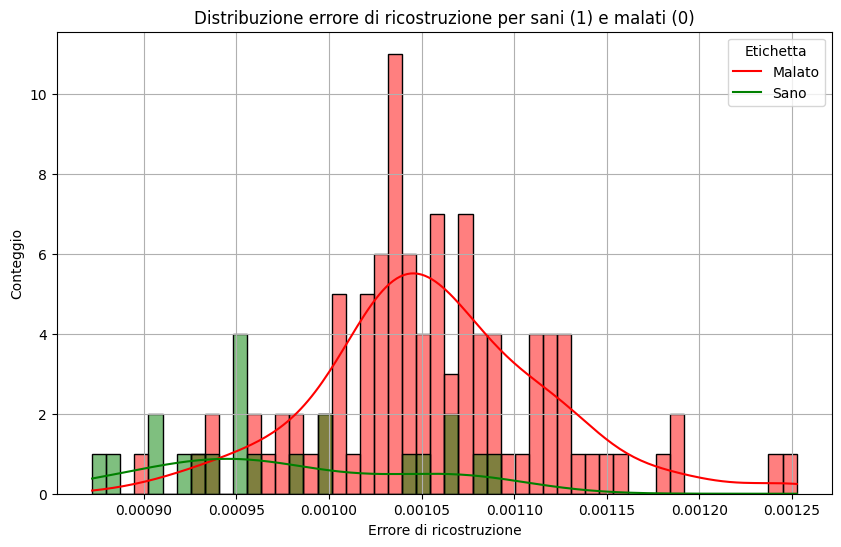

In [221]:
plt.figure(figsize=(10, 6))
sns.histplot(data=ps, x="reconstruction_error", hue="true_label", bins=50, kde=True,
             palette={1: "red", 0: "green"}, alpha=0.5)
plt.title("Distribuzione errore di ricostruzione per sani (1) e malati (0)")
plt.xlabel("Errore di ricostruzione")
plt.ylabel("Conteggio")
plt.legend(title="Etichetta", labels=["Malato", "Sano"])
plt.grid(True)
plt.show()


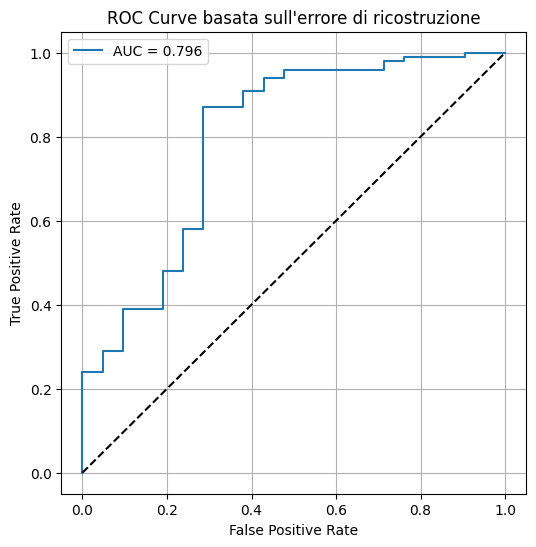

In [217]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_true = ps["true_label"]
errors = ps["reconstruction_error"]

# ROC
fpr, tpr, thresholds = roc_curve(y_true, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve basata sull'errore di ricostruzione")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


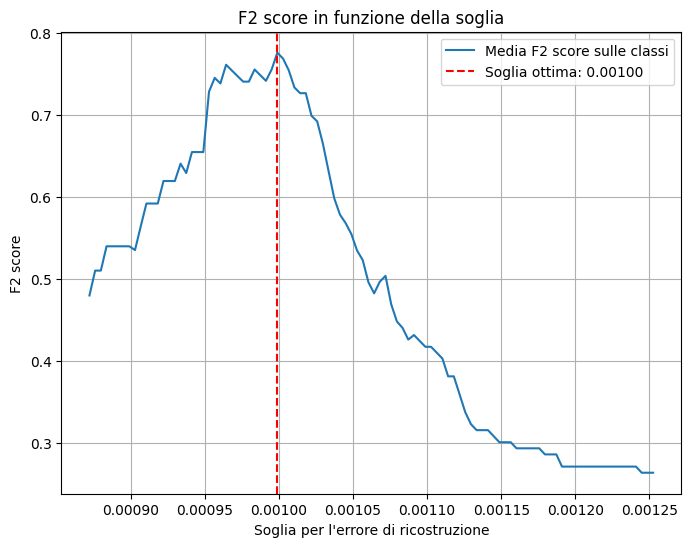

Miglior soglia per F2: 0.00100
F2: 0.7760


In [ ]:
# Scelta del valore della threshold di errore migliore con F-beta score

beta = 2 #recall pesa il doppio della precision
y_true = ps_val["true_label"].values
errors = ps_val["reconstruction_error"].values

thresholds = np.linspace(errors.min(), errors.max(), 100)
fbeta_scores = []
for t in thresholds:
  y_pred = (errors >= t).astype(int)
  fbeta = fbeta_score(y_true, y_pred, beta=beta, average='macro')
  fbeta_scores.append(fbeta)

best_idx = np.argmax(fbeta_scores)
best_thresh = thresholds[best_idx]
best_fbeta = fbeta_scores[best_idx]

# Visualizzazione della curva
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fbeta_scores, label=f"Media F{beta} score sulle classi")
plt.axvline(best_thresh, color='r', linestyle='--', label=f"Soglia ottima: {best_thresh:.5f}")
plt.xlabel("Soglia per l'errore di ricostruzione")
plt.ylabel(f"F{beta} score")
plt.title(f"F{beta} score in funzione della soglia")
plt.legend()
plt.grid(True)
plt.show()

print(f"Miglior soglia per F{beta}: {best_thresh:.5f}")
print(f"F{beta}: {best_fbeta:.4f}")

In [ ]:
# Aggiunta della label predetta in base all'errore di ricostruzione e confronto tra predicted_label e true_label

threshold = 0.00097
ps['predicted_label'] = (ps['reconstruction_error'] >= threshold).astype(int)

correct_matches = (ps['predicted_label'] == ps['true_label']).sum()
total = len(ps_grouped)

print(f"Corrispondenze corrette: {correct_matches} su {total} pazienti")
print(f"Accuratezza: {correct_matches / total:.2%}")
#print(ps[ps['predicted_label'] != ps['true_label']])

Corrispondenze corrette: 105 su 121 pazienti
Accuratezza: 86.78%


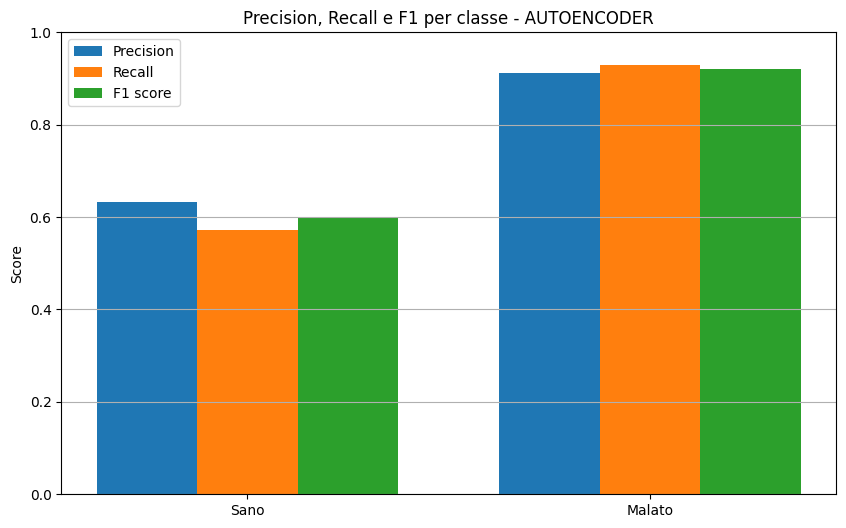


Accuracy: 0.8678

Classe 0: Precision=0.6316, Recall=0.5714, F1=0.6000

Classe 1: Precision=0.9118, Recall=0.9300, F1=0.9208
╒════════╤════════╤══════════╕
│        │   Sano │   Malato │
╞════════╪════════╪══════════╡
│ Sano   │     12 │        9 │
├────────┼────────┼──────────┤
│ Malato │      7 │       93 │
╘════════╧════════╧══════════╛


In [ ]:
# Calcolo delle metriche e visualizzazione grafici

y_true = ps['true_label'].to_numpy()
y_pred = ps['predicted_label'].to_numpy()
n_classes = len(np.unique(y_true))
y_true_onehot = onehot_encoding(y_true, n_classes)
y_pred_onehot = onehot_encoding(y_pred, n_classes)

accuracy = accuracy_classifier(y_pred_onehot, y_true_onehot)
precisions = precision_per_class(y_pred_onehot, y_true_onehot)
recalls = recall_per_class(y_pred_onehot, y_true_onehot)
f1s = f1_score_per_class(y_pred_onehot, y_true_onehot)
cm = confusion_matrix_class(y_pred_onehot, y_true_onehot)

# grafico
cn = [class_names[i] for i in range(n_classes)]
x = np.arange(n_classes)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precisions, width, label='Precision', color='tab:blue')
ax.bar(x, recalls, width, label='Recall', color='tab:orange')
ax.bar(x + width, f1s, width, label='F1 score', color='tab:green')

ax.set_xticks(x)
ax.set_xticklabels(cn)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Precision, Recall e F1 per classe - AUTOENCODER')
ax.legend()
ax.grid(axis='y')

plt.show()

# Stampa delle metriche
print(f"\nAccuracy: {accuracy:.4f}")
for i in range(n_classes):
    print(f"\nClasse {i}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")

table = cm.tolist() if hasattr(cm, 'tolist') else list(cm)
class_names = list(class_names)
print(tabulate(table, headers=class_names, showindex=class_names, tablefmt='fancy_grid'))

# **CONCLUSIONE**

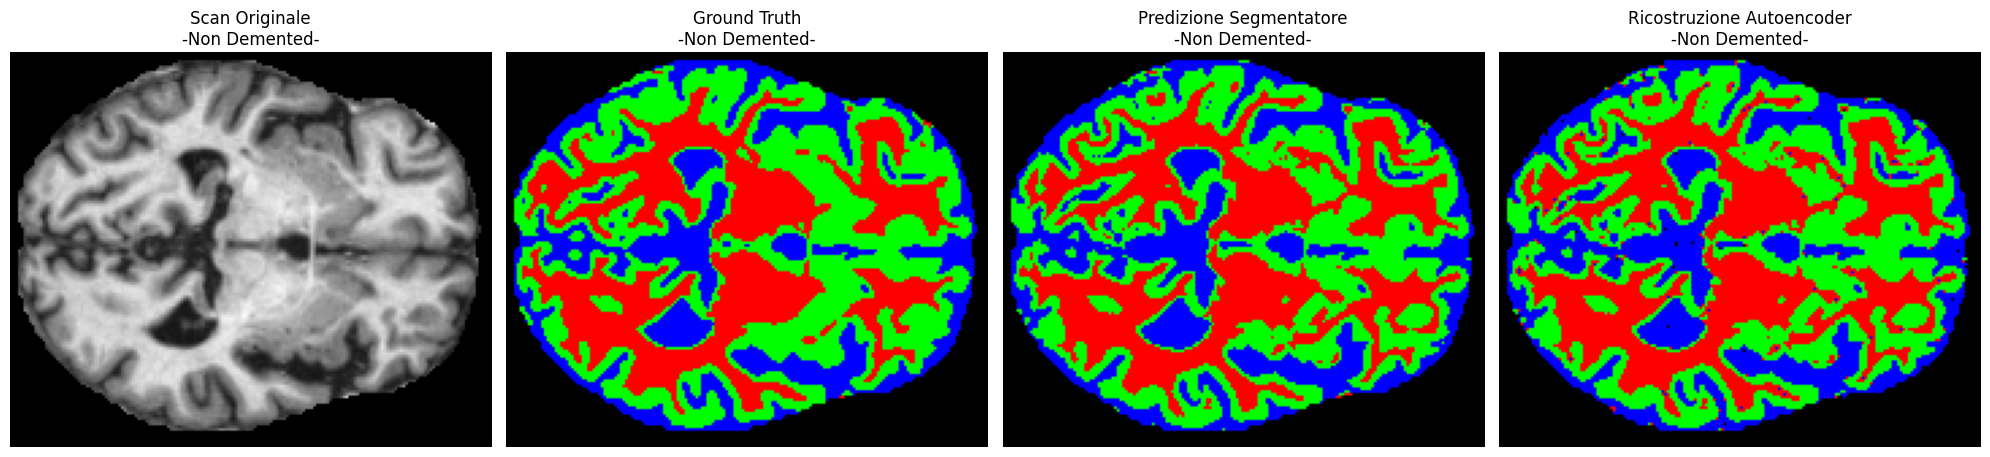

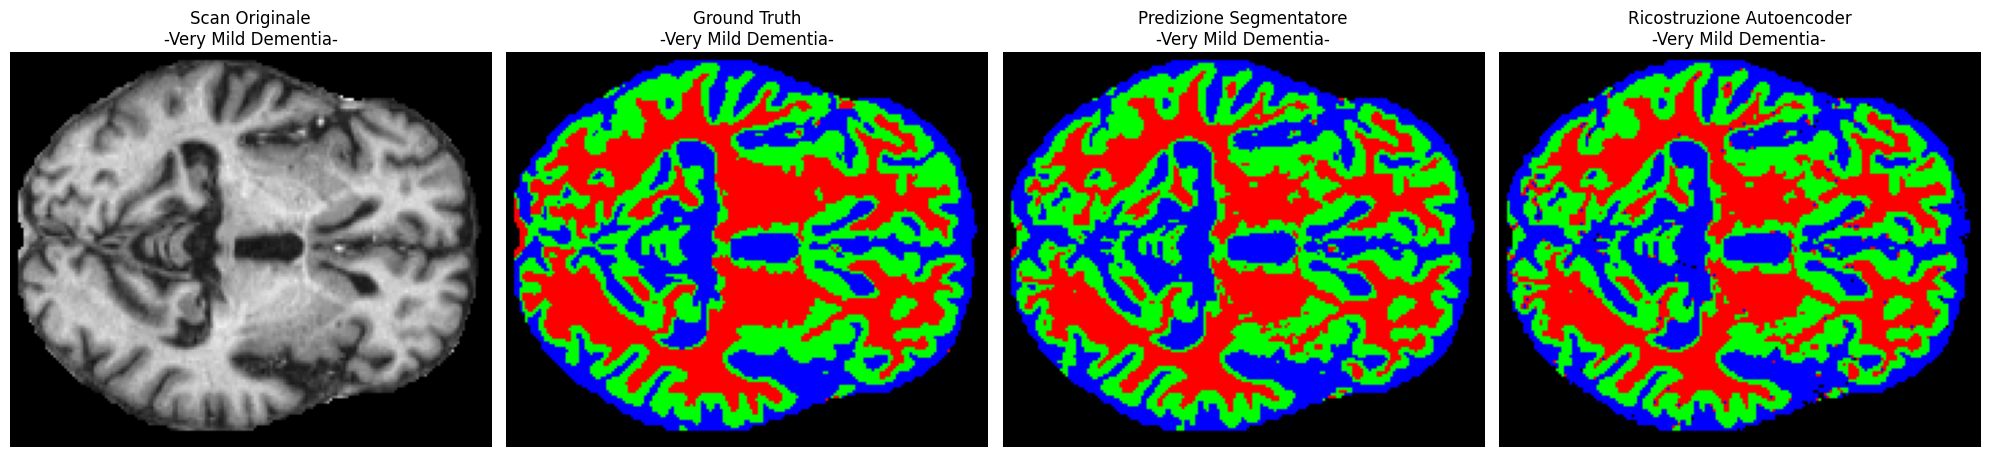

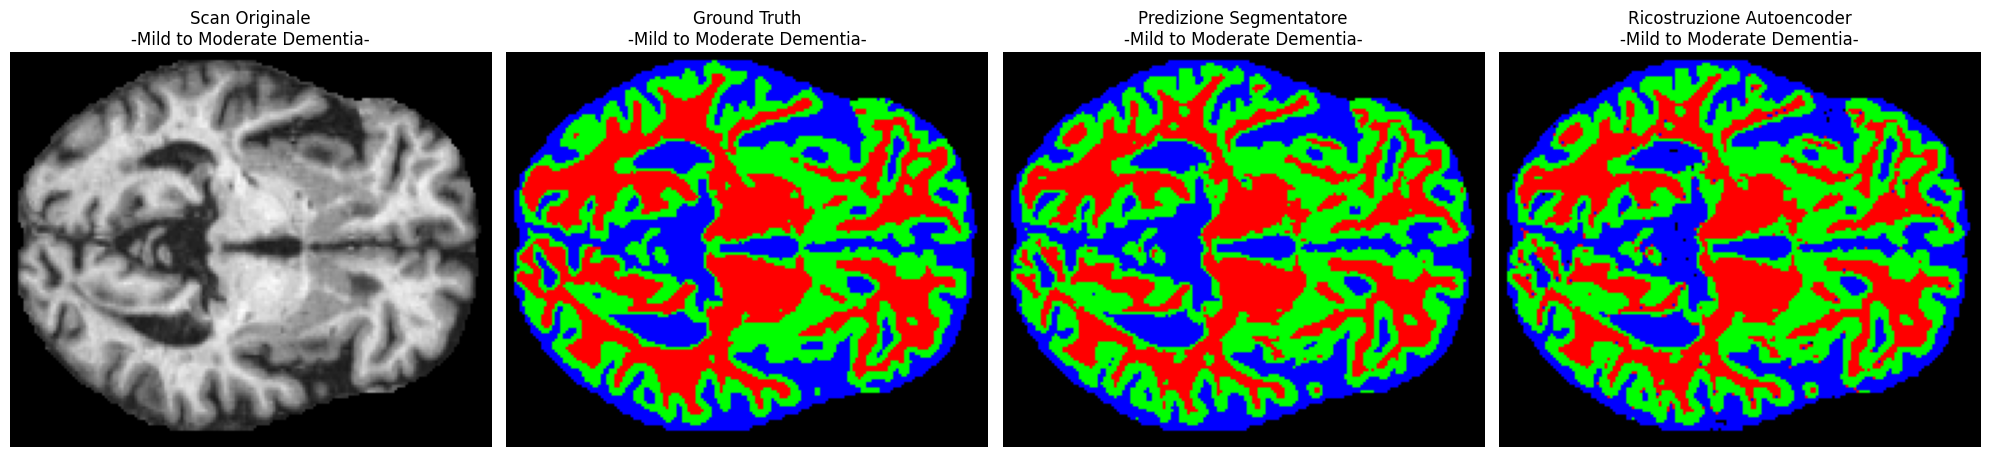

In [ ]:
# Visualizzazione delle immagini generate

pred_path= "/content/Alzheimer-detection-project/predizioni/test"
ae_path="/content/Alzheimer-detection-project/autoencoder/test"
for category in categories:
  category_path_target = os.path.join(oasis1_path, category)
  category_path_pred = os.path.join(pred_path, category)
  category_path_ae= os.path.join(ae_path, category)
  mri_path=os.path.join(category_path_target, 'mri scan')
  mri_segmented_path_target = os.path.join(category_path_target, 'mri segmented')
  mri_segmented_path_pred = os.path.join(category_path_pred, 'mri segmented')
  mri_segmented_path_ae = os.path.join(category_path_ae, 'mri segmented')
  folders=os.listdir(mri_segmented_path_ae)
  random_folder = random.choice(folders)
  folder_scan = random_folder.replace(' seg', '')

  patient_path_scan = os.path.join(mri_path, folder_scan)
  patient_path_pred= os.path.join(mri_segmented_path_pred, random_folder)
  patient_path_target= os.path.join(mri_segmented_path_target, random_folder)
  patient_path_ae= os.path.join(mri_segmented_path_ae, random_folder)

  scan_path = os.path.join(patient_path_scan, 'slice_70.png')
  scan = mpimg.imread(scan_path)
  img_path = os.path.join(patient_path_pred, 'slice_70_pred.png')
  img = mpimg.imread(img_path)
  img_path_ae = os.path.join(patient_path_ae, 'slice_70_pred.png')
  img_ae = mpimg.imread(img_path_ae)
  img_seg_path = os.path.join(patient_path_target, 'slice_70.npy')
  img_seg_onehot = np.load(img_seg_path)
  target_colored = colorize_prediction(img_seg_onehot)

  fig, axes = plt.subplots(1, 4, figsize=(20, 5))
  axes[0].imshow(scan,cmap='gray')
  axes[0].set_title(f"Scan Originale\n-{category}-")
  axes[0].axis('off')

  axes[1].imshow(target_colored)
  axes[1].set_title(f"Ground Truth\n-{category}-")
  axes[1].axis('off')

  axes[2].imshow(img)
  axes[2].set_title(f"Predizione Segmentatore\n-{category}-")
  axes[2].axis('off')

  axes[3].imshow(img_ae)
  axes[3].set_title(f"Ricostruzione Autoencoder\n-{category}-")
  axes[3].axis('off')

  plt.tight_layout()
  plt.show()